In [1]:
# sph related imports
from sph import *
from perlin import *
# neural network rlated imports
from torch.optim import Adam
from rbfConv import *
from torch_geometric.loader import DataLoader
from trainingHelper import *
# plotting/UI related imports
from plotting import *
import matplotlib as mpl
# plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']
from tqdm.notebook import trange, tqdm
from IPython.display import display, Latex
from datetime import datetime
from rbfNet import *
from tqdm.notebook import tqdm
import h5py
import matplotlib.colors as colors
%matplotlib notebook

In [2]:
torch.cuda.is_available()

True

In [3]:
trainingFiles = ['./output/' + f for f in os.listdir('./output/') if f.endswith('.hdf5')]
testingFiles = ['./outputTest/' + f for f in os.listdir('./outputTest/') if f.endswith('.hdf5')]
# print(testingFiles)

In [4]:
# Load generic settings
inFile = h5py.File(trainingFiles[0],'r')
minDomain = inFile.attrs['minDomain']
maxDomain = inFile.attrs['maxDomain']

baseArea = inFile.attrs['baseArea']
particleRadius = inFile.attrs['particleRadius']
particleSupport = inFile.attrs['particleSupport']

xsphConstant = inFile.attrs['xsphConstant']
diffusionAlpha = inFile.attrs['diffusionAlpha']
diffusionBeta = inFile.attrs['diffusionBeta']
kappa = inFile.attrs['kappa']
restDensity = inFile.attrs['restDensity']
c0 = inFile.attrs['c0']
dt = inFile.attrs['dt']

numParticles = inFile.attrs['numParticles']
timesteps = inFile.attrs['timesteps']

generator = inFile.attrs['generator']
inFile.close()

# Load generator settings
settings = {}
for f in trainingFiles:
    inFile = h5py.File(f,'r')
    generatorSettings = {}
    for k in inFile['generatorSettings'].attrs.keys():
        generatorSettings[k] = inFile['generatorSettings'].attrs[k]
#     print(generatorSettings)
    setup = {}
    setup['generatorSettings'] = generatorSettings
    setup['minDomain'] = inFile.attrs['minDomain']
    setup['maxDomain'] = inFile.attrs['maxDomain']

    setup['baseArea'] = inFile.attrs['baseArea']
    setup['particleRadius'] = inFile.attrs['particleRadius']
    setup['particleSupport'] = inFile.attrs['particleSupport']

    setup['xsphConstant'] = inFile.attrs['xsphConstant']
    setup['diffusionAlpha'] = inFile.attrs['diffusionAlpha']
    setup['diffusionBeta'] = inFile.attrs['diffusionBeta']
    setup['kappa'] = inFile.attrs['kappa']
    setup['restDensity'] = inFile.attrs['restDensity']
    setup['c0'] = inFile.attrs['c0']
    setup['dt'] = inFile.attrs['dt']

    setup['numParticles'] = inFile.attrs['numParticles']
    setup['timesteps'] = inFile.attrs['timesteps']

    setup['generator'] = inFile.attrs['generator']
    settings[f] = setup
    inFile.close()
    
for f in testingFiles:
    inFile = h5py.File(f,'r')
    generatorSettings = {}
    for k in inFile['generatorSettings'].attrs.keys():
        generatorSettings[k] = inFile['generatorSettings'].attrs[k]
#     print(generatorSettings)
    setup = {}
    setup['generatorSettings'] = generatorSettings
    setup['minDomain'] = inFile.attrs['minDomain']
    setup['maxDomain'] = inFile.attrs['maxDomain']

    setup['baseArea'] = inFile.attrs['baseArea']
    setup['particleRadius'] = inFile.attrs['particleRadius']
    setup['particleSupport'] = inFile.attrs['particleSupport']

    setup['xsphConstant'] = inFile.attrs['xsphConstant']
    setup['diffusionAlpha'] = inFile.attrs['diffusionAlpha']
    setup['diffusionBeta'] = inFile.attrs['diffusionBeta']
    setup['kappa'] = inFile.attrs['kappa']
    setup['restDensity'] = inFile.attrs['restDensity']
    setup['c0'] = inFile.attrs['c0']
    setup['dt'] = inFile.attrs['dt']

    setup['numParticles'] = inFile.attrs['numParticles']
    setup['timesteps'] = inFile.attrs['timesteps']

    setup['generator'] = inFile.attrs['generator']
    settings[f] = setup
    inFile.close()

<IPython.core.display.Javascript object>


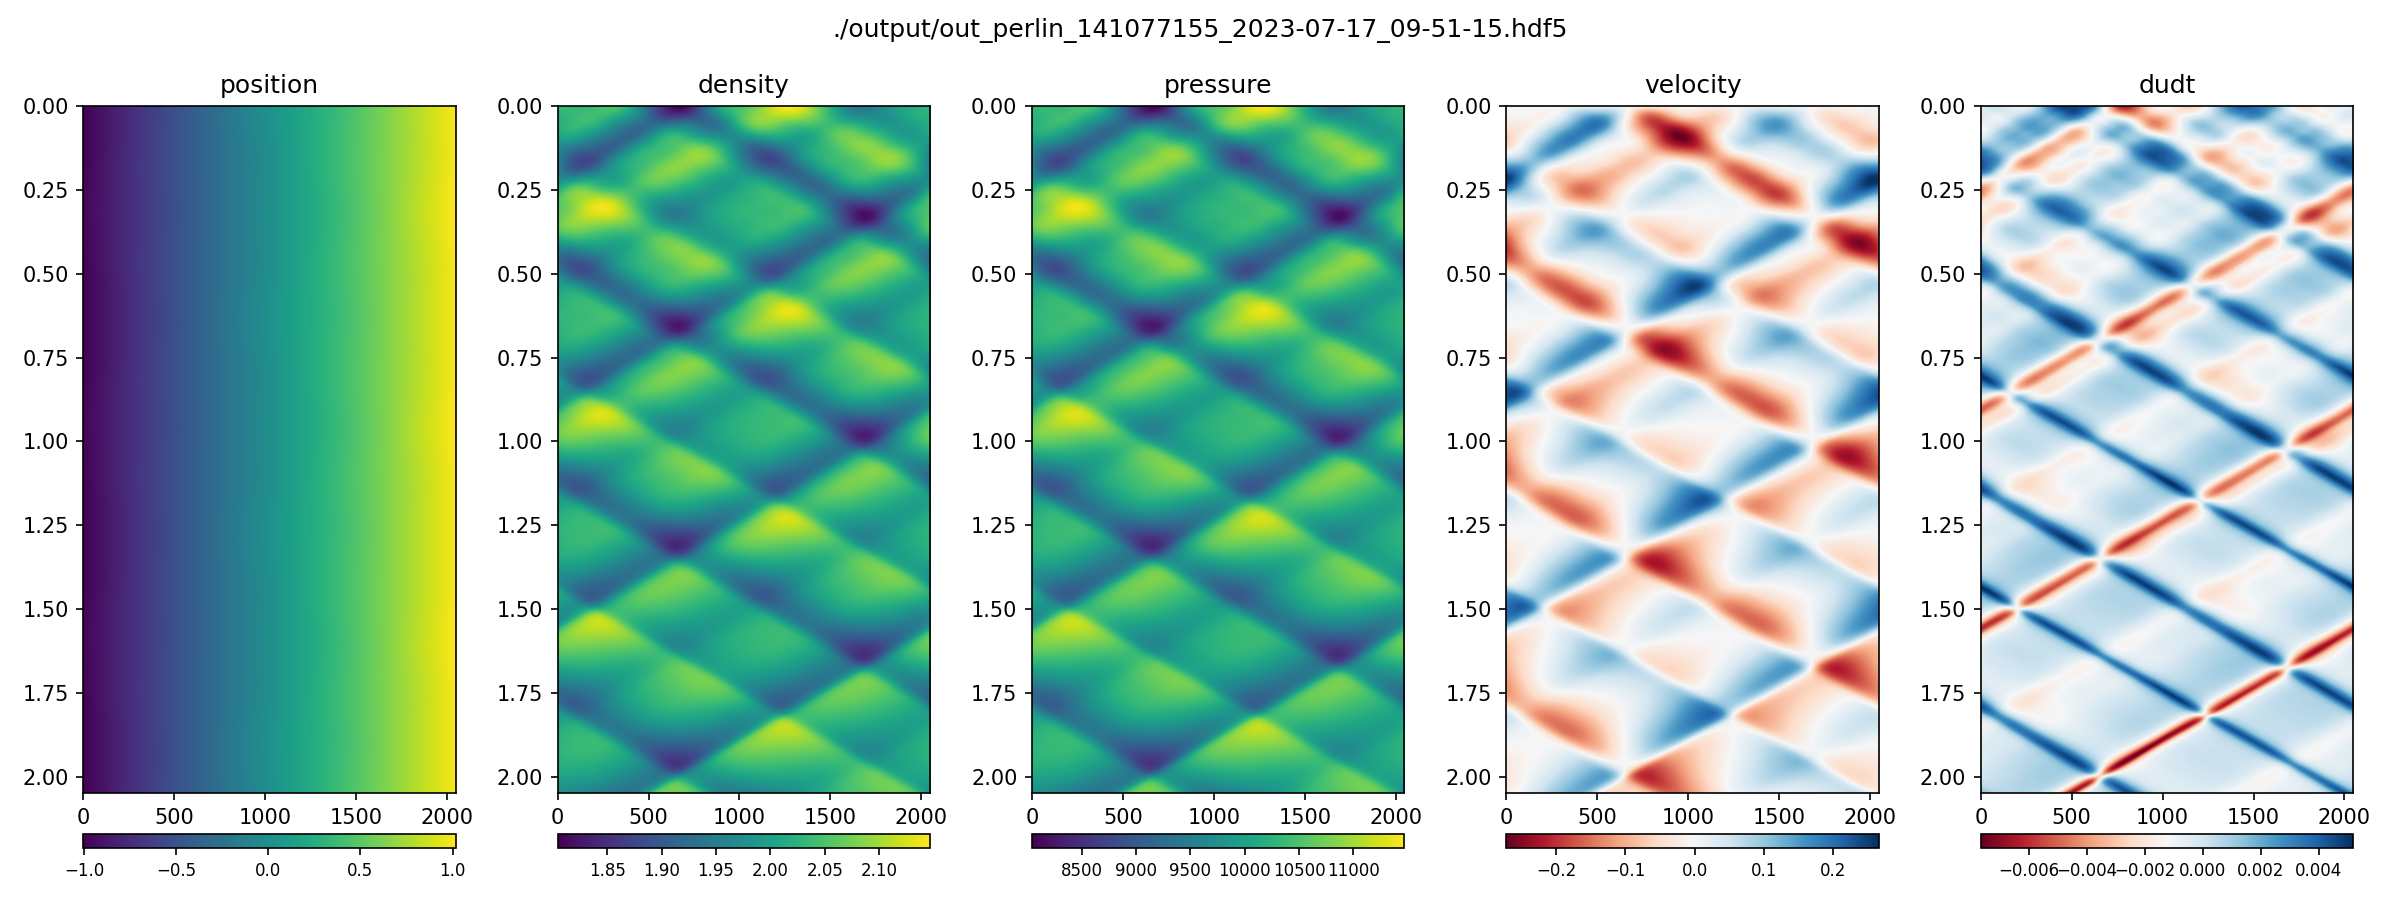

In [5]:
def loadFile(t, plot = False):
    inFile = h5py.File(t,'r')
    fluidPositions = np.array(inFile['simulationData']['fluidPosition'])
    
    fluidVelocities = np.array(inFile['simulationData']['fluidVelocities'])
    fluidDensity = np.array(inFile['simulationData']['fluidDensity'])
    fluidPressure = np.array(inFile['simulationData']['fluidPressure'])
    fluidAreas = np.array(inFile['simulationData']['fluidAreas'])
    dudt = np.array(inFile['simulationData']['dudt'])
    if plot:
        fig, axis = plt.subplots(1, 5, figsize=(16,6), sharex = False, sharey = False, squeeze = False)

        def plot(fig, axis, mat, title, cmap = 'viridis'):
            im = axis.imshow(mat, extent = [0,numParticles,dt * timesteps,0], cmap = cmap)
            axis.axis('auto')
            ax1_divider = make_axes_locatable(axis)
            cax1 = ax1_divider.append_axes("bottom", size="2%", pad="6%")
            cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
            cb1.ax.tick_params(labelsize=8) 
            axis.set_title(title)
        plot(fig,axis[0,0], fluidPositions, 'position')
        plot(fig,axis[0,1], fluidDensity, 'density')
        plot(fig,axis[0,2], fluidPressure, 'pressure')
        plot(fig,axis[0,3], fluidVelocities, 'velocity', 'RdBu')
        plot(fig,axis[0,4], dudt, 'dudt', 'RdBu')

        fig.suptitle(t)
        fig.tight_layout()
    inFile.close()
    return {'positions': torch.tensor(fluidPositions).type(torch.float32), 'density': torch.tensor(fluidDensity).type(torch.float32), 'pressure':torch.tensor(fluidPressure).type(torch.float32), 'area': torch.tensor(fluidAreas).type(torch.float32), 'velocity': torch.tensor(fluidVelocities).type(torch.float32), 'dudt' : torch.tensor(dudt).type(torch.float32)}
data = loadFile(trainingFiles[0], True)

In [6]:
# ns = int(np.sqrt(len(trainingFiles)))
# fig, axis = plt.subplots(ns, ns, figsize=(ns*6,ns * 2), sharex = True, sharey = True, squeeze = False)

# def plot(fig, axis, mat, title, cmap = 'viridis'):
#     im = axis.imshow(mat, extent = [0,dt * timesteps,numParticles,0], cmap = cmap)
#     axis.axis('auto')
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="2%", pad="6%")
#     cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
#     cb1.ax.tick_params(labelsize=8) 
#     axis.set_title(title)

# for i in range(ns):
#     for j in range(ns):
#         data = loadFile(trainingFiles[ns * j + i], False)
#         plot(fig,axis[i,j], data['velocity'].mT, trainingFiles[ns * j + i].split('/')[-1].split('.')[0].split('_')[2], 'RdBu')
# #         plot(fig,axis[i,j], data['dudt'].mT, trainingFiles[ns * j + i].split('/')[-1].split('.')[0].split('_')[2], 'RdBu')

# fig.tight_layout()

In [7]:

# fig, axis = plt.subplots(1, len(testingFiles), figsize=(len(testingFiles)*3,6), sharex = False, sharey = False, squeeze = False)

# def plot(fig, axis, mat, title, cmap = 'viridis'):
#     im = axis.imshow(mat, extent = [0,numParticles,dt * timesteps,0], cmap = cmap)
#     axis.axis('auto')
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("bottom", size="2%", pad="6%")
#     cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
#     cb1.ax.tick_params(labelsize=8) 
#     axis.set_title(title)
    
# for i in range(len(testingFiles)):
#     data = loadFile(testingFiles[i], False)
#     plot(fig,axis[0,i], data['velocity'], testingFiles[i].split('/')[-1].split('.')[0], 'RdBu')

# fig.suptitle('Test Samples')
# fig.tight_layout()

In [8]:
testingFiles = trainingFiles[-4:]
trainingFiles = trainingFiles[:-4]
print(len(testingFiles))

4


In [9]:
trainingData = {}
for f in tqdm(trainingFiles):
    trainingData[f] = loadFile(f, False)
testingData = {}
for f in tqdm(testingFiles):
    testingData[f] = loadFile(f, False)

# inFile.close()

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
print(trainingData[trainingFiles[0]]['positions'][:1024,:])
import matplotlib.colors as colors

tensor([[-1.0000, -0.9990, -0.9981,  ...,  0.9971,  0.9981,  0.9990],
        [-1.0000, -0.9990, -0.9981,  ...,  0.9971,  0.9981,  0.9990],
        [-1.0000, -0.9990, -0.9981,  ...,  0.9971,  0.9981,  0.9990],
        ...,
        [-0.9886, -0.9877, -0.9867,  ...,  1.0085,  1.0095,  1.0104],
        [-0.9887, -0.9878, -0.9868,  ...,  1.0084,  1.0093,  1.0103],
        [-0.9889, -0.9879, -0.9869,  ...,  1.0083,  1.0092,  1.0102]])


In [11]:
# def getStackedUpdates(positions, velocities, accelerations, offset):
#     dx = (velocities + accelerations)
#     x = dx.mT
#     cumsum = torch.cumsum(x, axis = 1)
#     s = torch.sum(x, axis = 1, keepdims=True)
#     r2lcumsum = x + s - cumsum
#     stacked = torch.hstack((r2lcumsum[:,:-offset] - r2lcumsum[:,offset:], r2lcumsum[:,-offset:]))
#     return stacked

    
    
    
# offset = 8

# positions = trainingData[trainingFiles[0]]['positions'][:1024,:]
# velocities = trainingData[trainingFiles[0]]['velocity'][:1024,:]
# accelerations = trainingData[trainingFiles[0]]['dudt'][:1024,:]
# dx = velocities + accelerations

# x = dx.mT
# cumsum = torch.cumsum(x, axis = 1)
# s = torch.sum(x, axis = 1, keepdims=True)
# r2lcumsum = x + s - cumsum
# stacked = torch.hstack((r2lcumsum[:,:-offset] - r2lcumsum[:,offset:], r2lcumsum[:,-offset:]))

# stacked = getStackedUpdates(positions, velocities, accelerations, offset)

# fig, axis = plt.subplots(3, 1, figsize=(16,9), sharex = True, sharey = False, squeeze = False)
# def imPlot(fig, axis, mat, title):
#     im = axis.imshow(mat, cmap = 'RdBu', norm = colors.Normalize(vmin = -np.max(np.abs(mat)), vmax = np.max(np.abs(mat))))
#     axis.axis('auto')
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="2%", pad="1%")
#     cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
#     cb1.ax.tick_params(labelsize=8) 
#     axis.set_title(title)
# imPlot(fig,axis[0,0], dx.mT.detach().cpu().numpy(), 'dx')
# # imPlot(fig,axis[1,0], cumsum.detach().cpu().numpy(), 'cumsum')
# # imPlot(fig,axis[2,0], (cumsum[:,1:] - cumsum[:,:-1]).detach().cpu().numpy(), 'cumsum diff')
# # imPlot(fig,axis[1,0], r2lcumsum.detach().cpu().numpy(), 'r2l cumsum')
# # imPlot(fig,axis[2,0], stacked.detach().cpu().numpy(), 'stacked')


# avgVelocity = torch.ones_like(stacked) * 0
# avgVelocity[:,offset:] = stacked[:,:-offset]
# for i in range(1,offset):
#     s = torch.vstack([dx[t,:] for t in range(i)])
#     summed = torch.sum(s, dim = 0)
#     avgVelocity[:,i] = summed
    
# # avgVelocity[:,:offset] = 0
# # avgVelocity[:,-offset:] = 0
# # stacked[:,:offset] = 0
# # stacked[:,-offset:] = 0

# # imPlot(fig,axis[1,0], avgVelocity.detach().cpu().numpy(), 'input Velocity')
# imPlot(fig,axis[1,0], velocities.mT.detach().cpu().numpy(), 'input Velocity')

# imPlot(fig,axis[2,0], (stacked - avgVelocity).detach().cpu().numpy(), 'input Velocity')


# # axis[2,0].imshow(stacked.detach().cpu().numpy(), cmap = 'RdBu')
# # axis[2,0].axis('auto')
# # axis[2,0].set_title('stacked')

# fig.tight_layout()

In [12]:
offset = 16
def getStackedUpdates(positions, velocities, accelerations, offset):
    dx = (velocities + accelerations)
    x = dx.mT
    cumsum = torch.cumsum(x, axis = 1)
    s = torch.sum(x, axis = 1, keepdims=True)
    r2lcumsum = x + s - cumsum
    stacked = torch.hstack((r2lcumsum[:,:-offset] - r2lcumsum[:,offset:], r2lcumsum[:,-offset:]))
    return stacked.mT


for f in tqdm(trainingFiles):
    trainingData[f]['stacked'] = getStackedUpdates(trainingData[f]['positions'], trainingData[f]['velocity'], trainingData[f]['dudt'], offset - 1)
for f in tqdm(testingFiles):
    testingData[f]['stacked'] = getStackedUpdates(testingData[f]['positions'], testingData[f]['velocity'], testingData[f]['dudt'], offset - 1)
#     trainingData[f]['averagedVelocity'] = torch.zeros

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

# Task: Learn density (1 timestep)

In [13]:
normalized = False # rbf normalization
batchSize = 4
maxUnrollsteps = 1
# offset = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
# device = 'cpu'
dataSet = []
for f in trainingFiles:
    nSteps = settings[f]['timesteps'] - maxUnrollsteps * (offset - 1)
    for j in range(offset - 1, nSteps):
        dataSet.append((f, j))
print('Dataset contains %d samples [%d files @ %d timesteps]' % (len(dataSet), len(trainingFiles), len(dataSet) / len(trainingFiles)))

Dataset contains 64576 samples [32 files @ 2018 timesteps]


In [14]:
from util import *

In [15]:
def loadTestcase(testingData, settings, f, frames, device, groundTruthFn, featureFn, offset):
    positions, velocities, areas, dudts, density, inputVelocity, outputVelocity, setup = getTestcase(testingData, settings, f, frames, device, offset)

    i, j, distance, direction = batchedNeighborsearch(positions, setup)
    x, u, v, rho, dudt, inVel, outVel = flatten(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity)

    x = x[:,None].to(device)    
    groundTruth = groundTruthFn(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity, i, j, distance, direction).to(device)
    distance = (distance * direction)[:,None].to(device)
    features = featureFn(x, u, v, rho, dudt, inVel, outVel).to(device)
#     print(groundTruth)
    return positions, velocities, areas, density, dudts, features, i, j, distance, groundTruth, x, u


In [16]:
def plotBatch(trainingData, settings, dataSet, bdata, device, offset, model = None):
    positions, velocities, areas, dudts, density, inputVelocity, outputVelocity, setup = loadBatch(trainingData, settings, dataSet, bdata, device, offset)
    i, j, distance, direction = batchedNeighborsearch(positions, setup)
    x, u, v, rho, dudt, inVel, outVel = flatten(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity)

    x = x[:,None].to(device)    
    groundTruth = groundTruthFn(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity, i, j, distance, direction).to(device)
    distance = (distance * direction)[:,None].to(device)
    features = featureFn(x, u, v, rho, dudt, inVel, outVel).to(device)

#     optimizer.zero_grad()
#     prediction = model(features.to(device), i.to(device), j.to(device), distance.to(device))[:,0]
#     lossTerm = lossFn(prediction, groundTruth)
#     loss = torch.mean(lossTerm)
    
    fig, axis = plt.subplot_mosaic('''AF
    BC
    DE''', figsize=(12,8), sharey = False, sharex = False)
    
    positions = torch.vstack(positions).mT.detach().cpu().numpy()
    vel = u.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    area = v.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    dudt = dudt.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    density = rho.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    inVel = inVel.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    outVel = outVel.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    gt = groundTruth.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    ft = features[:,0].reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    
    axis['A'].set_title('Position')
    axis['A'].plot(positions)
    axis['B'].set_title('Density')
    axis['B'].plot(positions, density)
    axis['C'].set_title('Difference')
    axis['C'].plot(positions, gt - ft)
    axis['D'].set_title('Instantenous Velocity')
    axis['D'].plot(positions, vel)
    axis['E'].set_title('Ground Truth')
    axis['E'].plot(positions, gt)
    axis['F'].set_title('Features[:,0]')
    axis['F'].plot(positions, ft)
    
    fig.tight_layout()
    
def plotTrainedBatch(trainingData, settings, dataSet, bdata, device, offset, modelState, groundTruthFn, featureFn, lossFn):
    positions, velocities, areas, dudts, density, inputVelocity, outputVelocity, setup = loadBatch(trainingData, settings, dataSet, bdata, device, offset)
    i, j, distance, direction = batchedNeighborsearch(positions, setup)
    x, u, v, rho, dudt, inVel, outVel = flatten(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity)

    x = x[:,None].to(device)    
    groundTruth = groundTruthFn(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity, i, j, distance, direction).to(device)
    distance = (distance * direction)[:,None].to(device)
    features = featureFn(x, u, v, rho, dudt, inVel, outVel).to(device)
    
    with torch.no_grad():
        prediction = modelState['model'](features.to(device), i.to(device), j.to(device), distance.to(device))[:,0]
        lossTerm = lossFn(prediction, groundTruth)
        loss = torch.mean(lossTerm)
    
    fig, axis = plt.subplot_mosaic('''ABC
    DEF''', figsize=(16,5), sharey = False, sharex = True)
    
    positions = torch.vstack(positions).mT.detach().cpu().numpy()
    vel = u.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    area = v.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    dudt = dudt.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    density = rho.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    inVel = inVel.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    outVel = outVel.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    gt = groundTruth.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    ft = features[:,0].reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    loss = lossTerm.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    pred = prediction.reshape(positions.transpose().shape).mT.detach().cpu().numpy()
    
    axis['A'].set_title('Density')
    axis['A'].plot(positions, density)
    axis['E'].set_title('Ground Truth - Features[:,0]')
    axis['E'].plot(positions, gt - ft)
    axis['B'].set_title('Ground Truth')
    axis['B'].plot(positions, gt)
    axis['D'].set_title('Features[:,0]')
    axis['D'].plot(positions, ft)
    axis['C'].set_title('Prediction')
    axis['C'].plot(positions, pred)
    axis['F'].set_title('Loss')
    axis['F'].plot(positions, loss)
    
    fig.tight_layout()
    
# plotBatch(trainingData, settings, dataSet, bdata, device, offset)

In [17]:
def buildMLP(layers, inputFeatures = 1):
    modules = []
    if len(layers) > 1:
        for i in range(len(layers) - 1):
            modules.append(nn.Linear(inputFeatures if i == 0 else layers[i-1],layers[i]))
            torch.nn.init.uniform_(modules[-1].weight,-0.05, 0.05)
    #         torch.nn.init.zeros_(modules[-1].weight)
            torch.nn.init.zeros_(modules[-1].bias)
            modules.append(nn.BatchNorm1d(layers[i]))
            modules.append(nn.ReLU())
        modules.append(nn.Linear(layers[-2],layers[-1]))
    else:
        modules.append(nn.Linear(inputFeatures,layers[-1]))        
    torch.nn.init.uniform_(modules[-1].weight,-0.05, 0.05)
    torch.nn.init.zeros_(modules[-1].bias)
    return nn.Sequential(*modules)

In [18]:
# positions, velocities, areas, dudts, density, inputVelocity, outputVelocity, setup = loadBatch(trainingData, settings, dataSet, bdata, device, offset)
# i, j, distance, direction = batchedNeighborsearch(positions, setup)
# x, u, v, rho, dudt, inVel, outVel = flatten(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity)

# x = x[:,None].to(device)    
# groundTruth = groundTruthFn(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity, i, j, distance, direction).to(device)
# distance = (distance * direction)[:,None].to(device)
# features = featureFn(x, u, v, rho, dudt, inVel, outVel).to(device)
# inputFeatures = features.shape[1]

In [19]:
# random.randint(0,2**30)

In [80]:
      
class mlpNetwork(nn.Module):
    def __init__(self,
                 feedThroughVertexFeatures = 0,
                 feedThroughEdgeFeatures = 0,
                 vertexHiddenLayout = [8,8,8], 
                 edgeHiddenLayout = [8,8,8],
                 vertexFeatures = [8,8,4,1],
                 messageFeatures = None,
                 edgeFeatures = None,
                 vertexMode = 'MessagePassing',
                 edgeMode = 'CConv',
                 edgeMLP = False,
                 inputEncode = False,
                 outputEncode = False,
                 inputEdgeEncode = False,
                 seed = None,
                 verbose = False):
        super(mlpNetwork, self).__init__()        
        if seed is not None:
            self.seed = seed
        else:
            self.seed = random.randint(0,2**30)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        np.random.seed(self.seed)
#         self.layout = layers
        self.inputVertexFeatures = vertexFeatures[0]
        self.outputVertexFeatures = vertexFeatures[-1]
        self.inputEdgeFeatures = edgeFeatures[0] if edgeFeatures is not None else 1
        self.edgeMLP = edgeMLP
#         self.outputEdgeFeatures = vertexFeatures[-1]
        self.vertexMode = vertexMode
        self.edgeMode = edgeMode
        self.vertexHiddenLayout = vertexHiddenLayout
        self.edgeHiddenLayout = edgeHiddenLayout
        self.inputEncode = inputEncode
        self.outputEncode = outputEncode
        self.inputEdgeEncode = inputEdgeEncode
        self.feedThroughVertexFeatures = feedThroughVertexFeatures
        self.feedThroughEdgeFeatures = feedThroughEdgeFeatures
        
        self.vertexFeatures = vertexFeatures
#         self.vertexFeatures = [e + feedThroughVertexFeatures for e in self.vertexFeatures]
        self.edgeFeatures = [1] + [1] * (len(vertexFeatures)) if edgeFeatures is None else edgeFeatures
        self.messageFeatures = self.edgeFeatures[1:] if messageFeatures is None else messageFeatures
#         self.edgeFeatures = [e + feedThroughEdgeFeatures for e in self.edgeFeatures]
        self.verbose = verbose
    
        if verbose:
            print('Building MLP MessagePassing network with %2d input features and %2d output features' % (vertexFeatures[0], vertexFeatures[-1]))
            print(f"Vertex Mode: {vertexMode} with vertex Features: [{' '.join([str(v) for v in vertexFeatures])}]")
            print(f"Processed Vertex Layout [{' '.join([str(v) for v in self.vertexFeatures])}]")
            print(f"Edge   Mode: {edgeMode} with edge Features  : [{' '.join([str(e) for e in edgeFeatures]) if edgeFeatures is not None else 'N/A'}]")
            print(f"Processed edge   Layout [{' '.join([str(v) for v in self.edgeFeatures])}]")
            print(f"Input Encoder: {'true' if inputEncode else 'false'}")
            print(f"Output Encoder: {'true' if outputEncode else 'false'}")
            print(f"Input Edge Encoder: {'true' if inputEdgeEncode else 'false'}")           
            print(f"Feed through features for vertices {feedThroughVertexFeatures} and edges {feedThroughEdgeFeatures}")
        
        
        if self.inputEncode:
            encoderLayout = vertexHiddenLayout + [self.vertexFeatures[1]]
            if verbose:
                print(f"Building inputEncoder from {self.vertexFeatures[0]} to {self.vertexFeatures[1]} with hidden layout {[{' '.join([str(v) for v in vertexHiddenLayout])}]}")
            self.vertexFeatures = self.vertexFeatures[1:]
            if verbose:
                print(f"New Vertex Layout: [{' '.join([str(v) for v in self.vertexFeatures])}]")
            self.inputEncoder = buildMLP(encoderLayout, inputFeatures = self.vertexFeatures[0] + feedThroughVertexFeatures, gain = 1)
            
        if self.outputEncode:
            encoderLayout = vertexHiddenLayout + [self.vertexFeatures[-1]]
            if verbose:
                print(f"Building outputEncoder from {self.vertexFeatures[-2] + feedThroughVertexFeatures} to {self.vertexFeatures[-1]} with hidden layout {[{' '.join([str(v) for v in vertexHiddenLayout])}]}")
            self.vertexFeatures = self.vertexFeatures[:-1]
            if verbose:
                print(f"New Vertex Layout: [{' '.join([str(v) for v in self.vertexFeatures])}]")
            self.outputEncoder = buildMLP(encoderLayout, inputFeatures = self.vertexFeatures[-1] + feedThroughVertexFeatures, gain = 1)
        
        if self.inputEdgeEncode:
            if vertexMode == 'PointNet':
                raise Exception(f"Vertex Mode 'PointNet' does not support edge features, please disable inputEdgeEncode")
            encoderLayout = edgeHiddenLayout + [self.edgeFeatures[1]]
            if verbose:
                print(f"Building inputEdgeEncoder from {1 + feedThroughEdgeFeatures} to {self.edgeFeatures[0]} with hidden layout {[{' '.join([str(v) for v in edgeHiddenLayout])}]}")
            self.edgeFeatures = self.edgeFeatures[1:]
            if verbose:
                print(f"New Edge Layout: [{' '.join([str(v) for v in self.edgeFeatures])}]")
            self.inputEdgeEncoder = buildMLP(encoderLayout, inputFeatures = 1 + feedThroughEdgeFeatures, gain = 1)
            
        self.messageFeatures = self.vertexFeatures[1:] if messageFeatures is None else messageFeatures
        
        if verbose:
            print(f"Final vertex Layout: [{' '.join([str(v) for v in self.vertexFeatures])}]")
            print(f"Final edge   Layout: [{' '.join([str(v) for v in self.edgeFeatures])}]")
            
            print('Starting construction of Message Passing Steps: ')
            for i in range(len(self.vertexFeatures)-1):
                if i != len(self.vertexFeatures) - 2:
                    print(f'\tLayer {i}: vertex Features: {self.vertexFeatures[i]} -> {self.vertexFeatures[i+1]}, edge Features: {self.edgeFeatures[i]} -> {self.edgeFeatures[i+1]}')
                else:                    
                    print(f'\tLayer {i}: vertex Features: {self.vertexFeatures[i]} -> {self.vertexFeatures[i+1]}')
        
        self.vertexModules = nn.ModuleList([])
        self.edgeModules = nn.ModuleList([])
        self.edgeMLPModules = nn.ModuleList([])
        if edgeMLP:            
            for i in range(len(self.edgeFeatures) - 1):
                layerInput = self.edgeFeatures[i] + feedThroughEdgeFeatures
                layerOutput = self.edgeFeatures[i+1]
                mlp = buildMLP(layers  = edgeHiddenLayout + [layerOutput], inputFeatures = layerInput, gain = 1)
                if verbose:
                    print('Processing Layer %2d' % i)
                    print(f"\tEdge Input: {layerInput}, edge Output: {layerOutput}")
#                     print(f"\tEdge Features: {self.edgeFeatures[i]}")
                self.edgeMLPModules.append(mlp)
        
        if vertexMode == 'PointNet':
            pass
        elif edgeMode == 'CConv':
            for i in range(len(self.vertexFeatures) - 1):
                if verbose:
                    print('Processing Layer %2d' % i)
                    print(f"\tVertex Input: {self.vertexFeatures[i]}, vertex Output: {self.vertexFeatures[i+1]}")
                    print(f"\tEdge Features: {self.edgeFeatures[i]}")
                layerInput = self.vertexFeatures[i] + feedThroughVertexFeatures
                layerOutput = self.messageFeatures[i] if self.vertexMode == 'MP-PDE' else self.vertexFeatures[i+1] #self.vertexFeatures[i+1] if messageFeatures is None else self.messageFeatures[i]
                mlp = buildMLP(layers  = edgeHiddenLayout + [layerInput * layerOutput], inputFeatures = self.edgeFeatures[i] + feedThroughEdgeFeatures)
                self.edgeModules.append(mlp)
        elif edgeMode == 'MP-PDE':
            for i in range(len(self.vertexFeatures) - 1):
                layerInput = self.vertexFeatures[i]*2 + feedThroughVertexFeatures + self.edgeFeatures[i] + feedThroughEdgeFeatures
                layerOutput =  self.vertexFeatures[i+1] if self.vertexMode == 'MessagePassing' else self.messageFeatures[i]
                if verbose:
                    print('Processing Layer %2d' % i)
                    print(f"\tLayer Input: {layerInput}, layer Output: {layerOutput}")
#                     print(f"\tEdge Features: {self.edgeFeatures[i]}")
                mlp = buildMLP(layers  = edgeHiddenLayout + [layerOutput], inputFeatures = layerInput)
                self.edgeModules.append(mlp)        
            pass
        else:
            raise Exception(f'Edge Mode {edgeMode} is not supported')
            
        if vertexMode == 'MessagePassing':
            pass
        elif vertexMode == 'PointNet':    
            for i in range(len(self.vertexFeatures) - 1):
                layerInput = self.vertexFeatures[i] + feedThroughVertexFeatures
                layerOutput = self.vertexFeatures[i+1]
                mlp = buildMLP(layers  = vertexHiddenLayout + [layerOutput], inputFeatures = layerInput, gain = 1)
                if verbose:
                    print('Processing Layer %2d' % i)
                    print(f"\tVertex Input: {layerInput}, vertex Output: {layerOutput}")
#                     print(f"\tEdge Features: {self.edgeFeatures[i]}")
                self.vertexModules.append(mlp)
        elif vertexMode == 'MP-PDE':
            for i in range(len(self.vertexFeatures) - 1):
                layerInput = self.vertexFeatures[i] + feedThroughVertexFeatures + (self.vertexFeatures[i] if messageFeatures is None else self.messageFeatures[i])
                layerOutput = self.vertexFeatures[i+1]
                mlp = buildMLP(layers  = vertexHiddenLayout + [layerOutput], inputFeatures = layerInput, gain = 1)
                if verbose:
                    print('Processing Layer %2d' % i)
                    print(f"\tVertex Input: {layerInput} ({self.vertexFeatures[i]} + {feedThroughVertexFeatures} + {(self.vertexFeatures[i] if messageFeatures is None else self.messageFeatures[i])}), vertex Output: {layerOutput}")
                self.vertexModules.append(mlp)            
        else :
            raise Exception(f'Vertex Mode {vertexMode} is not supported')
    def verbosePrint(self, s):
        if self.verbose:
            print(s)
        
    
    def forward(self, i, j, inputVertexFeatures, inputEdgeFeatures, feedThroughVertexFeatures = None, feedThroughEdgeFeatures = None ): 
        if self.inputVertexFeatures != inputVertexFeatures.shape[1]:
            raise Exception(f'Input shape {inputVertexFeatures.shape} does not match expected input feature size {self.inputFeatures}') 
        if self.inputEdgeFeatures != inputEdgeFeatures.shape[1] and self.edgeMode != 'PointNet':
            raise Exception(f'Input shape {inputEdgeFeatures.shape} does not match expected input feature size {self.inputFeatures}')
        if self.feedThroughVertexFeatures != 0 and feedThroughVertexFeatures == None:
            raise Exception(f'Expected {self.feedThroughVertexFeatures} feed through vertex features but got None')
        if self.feedThroughEdgeFeatures != 0 and feedThroughEdgeFeatures == None:
            raise Exception(f'Expected {self.feedThroughEdgeFeatures} feed through edge features but got None')
        if self.feedThroughVertexFeatures != 0 and feedThroughVertexFeatures.shape[1] != self.feedThroughVertexFeatures:
            raise Exception(f'Expected {self.feedThroughVertexFeatures} feed through vertex features but got input of shape {feedThroughVertexFeatures.shape}')
        if self.feedThroughEdgeFeatures != 0 and feedThroughEdgeFeatures.shape[1] != self.feedThroughEdgeFeatures:
            raise Exception(f'Expected {self.feedThroughEdgeFeatures} feed through edge features but got input of shape {feedThroughVertexFeatures.shape}')
        if self.feedThroughVertexFeatures == 0 and feedThroughVertexFeatures != None:
            raise Exception(f'Expected {self.feedThroughVertexFeatures} feed through vertex features but got input of shape {feedThroughVertexFeatures.shape}')
        if self.feedThroughEdgeFeatures == 0 and feedThroughEdgeFeatures != None:
            raise Exception(f'Expected {self.feedThroughEdgeFeatures} feed through edge features but got input of shape {feedThroughEdgeFeatures.shape}')
            
        
        self.verbosePrint('Running forward pass through NN:')
        self.verbosePrint(f"\tInput Vertex Features shape: {inputVertexFeatures.shape}")
        self.verbosePrint(f"\tInput Edge   Features shape: {inputEdgeFeatures.shape}")
        self.verbosePrint(f"\tNeighborhood shape: {i.shape} and {j.shape}")
        self.verbosePrint(f"\tFeed through vertex feature shape: {'N/A' if feedThroughVertexFeatures is None else feedThroughVertexFeatures.shape}")
        self.verbosePrint(f"\tFeed through edge   feature shape: {'N/A' if feedThroughEdgeFeatures is None else feedThroughEdgeFeatures.shape}")
            
        edgeFeatures = torch.clone(inputEdgeFeatures)
        vertexFeatures = torch.clone(inputVertexFeatures)
        
        if self.inputEncode:
            self.verbosePrint(f'Running input vertex encoder ({inputVertexFeatures.shape[1]} -> {self.vertexFeatures[0]})')
            vertexFeatures = self.inputEncoder(torch.hstack((vertexFeatures, feedThroughVertexFeatures)) if feedThroughVertexFeatures is not None else vertexFeatures)
        if self.inputEdgeEncode:
            self.verbosePrint(f'Running input edge   encoder ({edgeFeatures.shape[1]} -> {self.edgeFeatures[0]})')
            edgeFeatures = self.inputEdgeEncoder(torch.hstack((edgeFeatures, feedThroughEdgeFeatures)) if feedThroughEdgeFeatures is not None else edgeFeatures)
        
        if self.edgeMode == 'CConv':
            for l, layer in enumerate(self.edgeModules):
                self.verbosePrint('Processing Layer %2d' % l)
                self.verbosePrint(f"\tVertex Input: {self.vertexFeatures[l]}, vertex Output: {self.vertexFeatures[l+1]}")
                self.verbosePrint(f"\tEdge Features: {self.edgeFeatures[l]}")
                if feedThroughEdgeFeatures is not None:
                    filterOutput = layer(torch.hstack((edgeFeatures,feedThroughEdgeFeatures))).reshape(i.shape[0], self.vertexFeatures[l] + self.feedThroughVertexFeatures, self.messageFeatures[l] if self.vertexMode == 'MP-PDE' else self.vertexFeatures[l+1])
                else:
                    filterOutput = layer(edgeFeatures).reshape(i.shape[0], self.vertexFeatures[l] + self.feedThroughVertexFeatures, self.messageFeatures[l] if self.vertexMode == 'MP-PDE' else self.vertexFeatures[l+1])
                if feedThroughVertexFeatures is not None:
                    vertexFeatures = torch.hstack((vertexFeatures, feedThroughVertexFeatures))
                    
                self.verbosePrint(f"\tProcessed edge mlp, input shape {edgeFeatures.shape} -> output shape {filterOutput.shape}")
                self.verbosePrint(f"\tVertex Feature Shape {vertexFeatures.shape}")
                message = torch.sum(filterOutput * vertexFeatures[j].unsqueeze(2), dim = 1)
                self.verbosePrint(f"\tMessage shape: {message.shape}")
                aggrMessage = scatter_sum(message, i, dim = 0, dim_size = vertexFeatures.shape[0])
                self.verbosePrint(f"\tAggregated message shape: {aggrMessage.shape}")

                if self.vertexMode == 'MessagePassing':
#                     if feedThroughVertexFeatures is None:
                    vertexFeatures = aggrMessage
#                     elif feedThroughVertexFeatures is not None and self.outputEncode:
#                         vertexFeatures = torch.hstack((aggrMessage, feedThroughVertexFeatures))
#                     elif feedThroughVertexFeatures is not None and not self.outputEncode and l == len(self.edgeModules) - 1:
#                         vertexFeatures = aggrMessage
                    if feedThroughVertexFeatures is not None and self.outputEncode and l == len(self.edgeModules)-1:
                        vertexFeatures = torch.hstack((vertexFeatures, feedThroughVertexFeatures))
                elif self.vertexMode == 'MP-PDE':
#                     if feedThroughVertexFeatures is None:
#                     if l == 0:
#                     if feedThroughVertexFeatures is not None:
#                         vertexFeatures = torch.hstack((vertexFeatures, feedThroughVertexFeatures))
#                     print('vertexFeatures:', vertexFeatures.shape)
#                     print('feedThroughVertexFeatures:', feedThroughVertexFeatures.shape)
#                     print('aggrMessage:', aggrMessage.shape)
            
                    vertexFeatures = self.vertexModules[l](torch.hstack((vertexFeatures, aggrMessage)))
#                     elif feedThroughVertexFeatures is not None:
#                         vertexFeatures = self.vertexModules[l](torch.hstack((vertexFeatures, aggrMessage, feedThroughVertexFeatures)))
#                     if self.outputEncode and l == len(self.vertexModules) - 1 and feedThroughVertexFeatures is not None:
#                         vertexFeatures = torch.hstack((vertexFeatures, feedThroughVertexFeatures))
                    if feedThroughVertexFeatures is not None and self.outputEncode and l == len(self.edgeModules)-1:
                        vertexFeatures = torch.hstack((vertexFeatures, feedThroughVertexFeatures))
#                         vertexFeatures = torch.hstack((vertexFeatures, feedThroughVertexFeatures))
#                     elif feedThroughVertexFeatures is not None and not self.outputEncode and l == len(self.edgeModules) - 1:
#                         vertexFeatures = self.vertexModules[l](torch.hstack((vertexFeatures, aggrMessage)))
                else:
                    raise Exception(f'Vertex Mode {self.vertexMode} x Edge mode {self.edgeMode} combination is not supported')     
                if self.edgeMLP and l != len(self.edgeModules)-1:
#                     print(l, len(self.vertexModules), len(self.edgeMLPModules))
                    self.verbosePrint(f"\tRunning edge MLP {edgeFeatures.shape[1] + feedThroughEdgeFeatures.shape[1] if feedThroughEdgeFeatures is not None else edgeFeatures.shape[1]} -> {self.edgeFeatures[l+1]}")
                    edgeFeatures = self.edgeMLPModules[l](torch.hstack((edgeFeatures, feedThroughEdgeFeatures)) if feedThroughEdgeFeatures is not None else edgeFeatures)
                    
                self.verbosePrint(f"\tNew Vertex feature shape: {vertexFeatures.shape}")     
        elif self.edgeMode == 'MP-PDE':
            for l, layer in enumerate(self.edgeModules):
                self.verbosePrint('Processing Layer %2d' % l)
                self.verbosePrint(f"\tVertex Input: {self.vertexFeatures[l]}, vertex Output: {self.vertexFeatures[l+1]}")
                self.verbosePrint(f"\tEdge Features: {self.edgeFeatures[l]}")
                if feedThroughEdgeFeatures is not None:
                    self.verbosePrint(f"\tGathered Edge Features: {edgeFeatures.shape[1]} + {feedThroughEdgeFeatures.shape[1]} via feed through")
                    eFeatures = torch.hstack((edgeFeatures,feedThroughEdgeFeatures))
                else:
                    self.verbosePrint(f"\tGathered Edge Features: {edgeFeatures.shape[1]}")
                    eFeatures = edgeFeatures
                if feedThroughVertexFeatures is not None:
                    self.verbosePrint(f"\tGathered Vertex Features: {vertexFeatures.shape[1]} + {feedThroughVertexFeatures.shape[1]} via feed through")
                    vFeatures = torch.hstack((vertexFeatures[i], vertexFeatures[j],feedThroughVertexFeatures[j]))
                else:
                    self.verbosePrint(f"\tGathered Vertex Features: {vertexFeatures.shape[1]}")
                    vFeatures = torch.hstack((vertexFeatures[i], vertexFeatures[j]))
#                 print(vFeatures.shape, eFeatures.shape)
                features = torch.hstack((eFeatures, vFeatures))         
                self.verbosePrint(f"\tProcessed edge mlp, input shape {features.shape}")           
                message = layer(features)
#                 message = torch.sum(filterOutput * vertexFeatures[j].unsqueeze(2), dim = 1)
                self.verbosePrint(f"\tMessage shape: {message.shape}")
                aggrMessage = scatter_sum(message, i, dim = 0, dim_size = vertexFeatures.shape[0])
                self.verbosePrint(f"\tAggregated message shape: {aggrMessage.shape}")

                if self.vertexMode == 'MessagePassing':
#                     if feedThroughVertexFeatures is None:
                    vertexFeatures = aggrMessage
#                     elif feedThroughVertexFeatures is not None and self.outputEncode:
#                         vertexFeatures = torch.hstack((aggrMessage, feedThroughVertexFeatures))
#                     elif feedThroughVertexFeatures is not None and not self.outputEncode and l == len(self.edgeModules) - 1:
#                         vertexFeatures = aggrMessage
                    if feedThroughVertexFeatures is not None and self.outputEncode and l == len(self.edgeModules)-1:
                        vertexFeatures = torch.hstack((vertexFeatures, feedThroughVertexFeatures))
#                     print(vertexFeatures.shape)
                elif self.vertexMode == 'MP-PDE':
            
#                     if feedThroughVertexFeatures is None:
#                     if l == 0:
                    if feedThroughVertexFeatures is not None:
                        vertexFeatures = torch.hstack((vertexFeatures, feedThroughVertexFeatures))
                    vertexFeatures = self.vertexModules[l](torch.hstack((vertexFeatures, aggrMessage)))
#                     elif feedThroughVertexFeatures is not None:
#                         vertexFeatures = self.vertexModules[l](torch.hstack((vertexFeatures, aggrMessage, feedThroughVertexFeatures)))
#                     if self.outputEncode and l == len(self.vertexModules) - 1 and feedThroughVertexFeatures is not None:
#                         vertexFeatures = torch.hstack((vertexFeatures, feedThroughVertexFeatures))
                    if (feedThroughVertexFeatures is not None and self.outputEncode and l == len(self.vertexModules)-1):
                        vertexFeatures = torch.hstack((vertexFeatures, feedThroughVertexFeatures))
#                         vertexFeatures = torch.hstack((vertexFeatures, feedThroughVertexFeatures))
#                     elif feedThroughVertexFeatures is not None and not self.outputEncode and l == len(self.edgeModules) - 1:
#                         vertexFeatures = self.vertexModules[l](torch.hstack((vertexFeatures, aggrMessage)))
                else:
                    raise Exception(f'Vertex Mode {self.vertexMode} x Edge mode {self.edgeMode} combination is not supported')     
                if self.edgeMLP and l != len(self.vertexModules)-1:
                    self.verbosePrint(f"\tRunning edge MLP {edgeFeatures.shape[1] + feedThroughEdgeFeatures.shape[1] if feedThroughEdgeFeatures is not None else edgeFeatures.shape[1]} -> {self.edgeFeatures[l+1]}")
                    edgeFeatures = self.edgeMLPModules[l](torch.hstack((edgeFeatures, feedThroughEdgeFeatures)) if feedThroughEdgeFeatures is not None else edgeFeatures)
                self.verbosePrint(f"\tNew Vertex feature shape: {vertexFeatures.shape}")      
        elif self.edgeMode == 'PointNet':
            for l, layer in enumerate(self.vertexModules):
                self.verbosePrint('Processing Layer %2d' % l)
                self.verbosePrint(f"\tVertex Input: {self.vertexFeatures[l]}, vertex Output: {self.vertexFeatures[l+1]}")
                if feedThroughVertexFeatures is None:
                    vertexFeatures = self.vertexModules[l](vertexFeatures)
                elif feedThroughVertexFeatures is not None:
                    vertexFeatures = self.vertexModules[l](torch.hstack((vertexFeatures, feedThroughVertexFeatures)))
                if self.outputEncode and l == len(self.vertexModules) - 1:
                    vertexFeatures = torch.hstack((vertexFeatures, feedThroughVertexFeatures))
        else:
            raise Exception(f'Vertex Mode {self.vertexMode} x Edge mode {self.edgeMode} combination is not supported')
            
        if self.outputEncode:
            self.verbosePrint(f'Running output vertex decoder ({self.vertexFeatures[-1] + self.feedThroughVertexFeatures} -> {self.outputVertexFeatures})')
            vertexFeatures = self.outputEncoder(vertexFeatures)
        return vertexFeatures# / particleSupport
    
    def printProcess(self): 
        self.verbosePrint('Running forward pass through NN:')
        self.verbosePrint(f"Input Vertex Features shape: {self.inputVertexFeatures}")
        self.verbosePrint(f"Input Edge   Features shape: {self.inputEdgeFeatures}")
        
        self.verbosePrint(f"Feed through vertex feature shape: {'N/A' if self.feedThroughVertexFeatures == 0 else self.feedThroughVertexFeatures}")
        self.verbosePrint(f"Feed through edge   feature shape: {'N/A' if self.feedThroughEdgeFeatures == 0 else self.feedThroughEdgeFeatures}")
        
        print('---------------------------------------\n')
        
        stepCounter = 0
        feedThroughVertexText = f"feedThrough @ {self.feedThroughVertexFeatures} ..." if self.feedThroughVertexFeatures != 0 else ''
        feedThroughEdgeText = f"feedThrough @ {self.feedThroughEdgeFeatures} ..." if self.feedThroughEdgeFeatures != 0 else ''
        
        print(f'[{stepCounter:3}] - Pre-Processing')
        stepCounter = stepCounter + 1
        if self.inputEncode:
            inputShape = self.inputVertexFeatures if self.feedThroughVertexFeatures == 0 else self.inputVertexFeatures + self.feedThroughVertexFeatures
            outputShape = self.vertexFeatures[0]
            print(f'[{stepCounter:3}] - Vertex OP - {"Input encoder":24}: [inputVertexFeatures @ {inputShape} ... {feedThroughVertexText}] -> [{outputShape}]')
            stepCounter = stepCounter + 1
        if self.inputEdgeEncode:
            inputShape = self.inputEdgeFeatures if self.feedThroughEdgeFeatures == 0 else self.inputEdgeFeatures + self.feedThroughEdgeFeatures
            outputShape = self.edgeFeatures[0]
            print(f'[{stepCounter:3}] - Edge   OP - {"Input encoder":24}: [  inputEdgeFeatures @ {inputShape} ... {feedThroughEdgeText}] -> [{outputShape}]')
            stepCounter = stepCounter + 1
#         return
        
        if self.edgeMode == 'CConv':     
            print(f'[{stepCounter:3}] - Layer Processing')
            stepCounter = stepCounter + 1       
            for l, layer in enumerate(self.edgeModules):
                print(f'[{stepCounter:3}] - Layer {l:2} - \tEdge OP (Message Passing): [edgeFeatures @ {self.edgeFeatures[l]} ... {feedThroughEdgeText}] @ {self.edgeFeatures[l] + self.feedThroughEdgeFeatures} -> [message @ {self.vertexFeatures[l] + self.feedThroughVertexFeatures, self.vertexFeatures[l+1]}]')
                print(f'[{stepCounter:3}] - Layer {l:2} - \tReshape OP: [message @ {self.vertexFeatures[l] + self.feedThroughVertexFeatures, self.vertexFeatures[l+1]}] -> M @ {self.vertexFeatures[l] + self.feedThroughVertexFeatures} x {self.vertexFeatures[l+1]}')
                print(f'[{stepCounter:3}] - Layer {l:2} - \tMessage aggregation : M @ {self.vertexFeatures[l] + self.feedThroughVertexFeatures} x {self.vertexFeatures[l+1]} x [vertexFeatures @ {self.vertexFeatures[l]} ... {feedThroughVertexText}]')
                if self.vertexMode == 'MessagePassing':
                    if self.feedThroughVertexFeatures != 0 and self.outputEncode and l == len(self.edgeModules)-1:
                        print(f'[{stepCounter:3}] - Layer {l:2} - \tOutput   Gathering (last step)-> Vertex Features: [vertexFeatures @ {self.vertexFeatures[l]} ... {feedThroughVertexText}]')
                        stepCounter = stepCounter + 1
                elif self.vertexMode == 'MP-PDE':
                    if l == 0:
                        if feedThroughVertexFeatures is not None:
                            print(f'[{stepCounter:3}] - Layer {l:2} - \tInput expansion: [vertexFeatures @ {self.vertexFeatures[0]}] -> [vertexFeatures @ {self.vertexFeatures[0]} ... {feedThroughVertexText}]  ')           
                    print(f'[{stepCounter:3}] - Layer {l:2} - \tVertex MLP (MP-PDE)      : [messageFeatures @ {self.messageFeatures[l]} ... vertexFeatures @ {self.vertexFeatures[l]} ... {feedThroughVertexText}] -> [vertexFeatures @ {self.vertexFeatures[l + 1]}]')
                    stepCounter = stepCounter + 1
                    if self.feedThroughVertexFeatures != 0 and self.outputEncode and l == len(self.edgeModules)-1:
                        print(f'[{stepCounter:3}] - Layer {l:2} - \tOutput   Gathering (last step)-> Vertex Features: [vertexFeatures @ {self.vertexFeatures[l]} ... {feedThroughVertexText}]')
                        stepCounter = stepCounter + 1
                else:
                    raise Exception(f'Vertex Mode {self.vertexMode} x Edge mode {self.edgeMode} combination is not supported')     
                if self.edgeMLP and l != len(self.edgeModules)-1:
                    print(f'[{stepCounter:3}] - Layer {l:2} - \tEdge MLP (GNS)           : [edgeFeatures @ {self.edgeFeatures[l]} ... {feedThroughEdgeText}] @ {self.edgeFeatures[l] + self.feedThroughEdgeFeatures} -> [edgeFeatures @ {self.edgeFeatures[l+1]}]')
                    stepCounter = stepCounter + 1
                    
#                 self.verbosePrint(f"\tNew Vertex feature shape: {vertexFeatures.shape}")     
        elif self.edgeMode == 'MP-PDE':
            print(f'[{stepCounter:3}] - Layer Processing')
            stepCounter = stepCounter + 1
            for l, layer in enumerate(self.edgeModules):
                print(f'[{stepCounter:3}] - Layer {l:2} - \tEdge OP (Message Passing): [edgeFeatures @ {self.edgeFeatures[l]} ... {feedThroughEdgeText} vertexFeatures[i] @ {self.vertexFeatures[l]} vertexFeatures[j] @ {self.vertexFeatures[l]} ... {feedThroughVertexText}] @ {self.edgeFeatures[l] + self.vertexFeatures[l] * 2 + self.feedThroughEdgeFeatures + self.feedThroughVertexFeatures} -> [message @ {self.messageFeatures[l]}]')
                stepCounter = stepCounter + 1
                if self.vertexMode == 'MessagePassing':
                    if self.feedThroughVertexFeatures != 0 and self.outputEncode and l == len(self.edgeModules)-1:
                        print(f'[{stepCounter:3}] - Layer {l:2} - \tOutput   Gathering (last step)-> Vertex Features: [vertexFeatures @ {self.vertexFeatures[l]} ... {feedThroughVertexText}]')
                        stepCounter = stepCounter + 1
                elif self.vertexMode == 'MP-PDE':
                    print(f'[{stepCounter:3}] - Layer {l:2} - \tVertex MLP (MP-PDE)      : [messageFeatures @ {self.messageFeatures[l]} ... vertexFeatures @ {self.vertexFeatures[l]} ... {feedThroughVertexText}] -> [vertexFeatures @ {self.vertexFeatures[l + 1]}]')
                    stepCounter = stepCounter + 1
                    if self.feedThroughVertexFeatures != 0 and self.outputEncode and l == len(self.edgeModules)-1:
                        print(f'[{stepCounter:3}] - Layer {l:2} - \tOutput   Gathering (last step)-> Vertex Features: [vertexFeatures @ {self.vertexFeatures[l]} ... {feedThroughVertexText}]')
                        stepCounter = stepCounter + 1
                else:
                    raise Exception(f'Vertex Mode {self.vertexMode} x Edge mode {self.edgeMode} combination is not supported')     
                if self.edgeMLP and l != len(self.vertexModules)-1:
                    print(f'[{stepCounter:3}] - Layer {l:2} - \tEdge MLP (GNS)           : [edgeFeatures @ {self.edgeFeatures[l]} ... {feedThroughEdgeText}] @ {self.edgeFeatures[l] + self.feedThroughEdgeFeatures} -> [edgeFeatures @ {self.edgeFeatures[l+1]}]')
                    stepCounter = stepCounter + 1
        elif self.edgeMode == 'PointNet':
            print(f'[{stepCounter:3}] - Layer Processing')
            for l, layer in enumerate(self.vertexModules):
                print(f'[{stepCounter:3}] - Layer {l:2} - \tVertex MLP (MP-PDE)      : [messageFeatures @ {self.vertexFeatures[l]} ... {feedThroughVertexText}] -> [vertexFeatures @ {self.vertexFeatures[l + 1]}]')
                stepCounter = stepCounter + 1
        else:
            raise Exception(f'Vertex Mode {self.vertexMode} x Edge mode {self.edgeMode} combination is not supported')
            
        print(f'[{stepCounter:3}] - Post-Processing')
        stepCounter = stepCounter + 1
        if self.outputEncode:
#             self.verbosePrint(f'Running output vertex decoder ({self.vertexFeatures[-1] + self.feedThroughVertexFeatures} -> {self.outputVertexFeatures})')
#             vertexFeatures = self.outputEncoder(vertexFeatures)
            print(f'[{stepCounter:3}] - Vertex OP - {"Output decoder":24}: [vertexFeatures @ {self.vertexFeatures[-1]} ... {feedThroughVertexText}] -> [{self.outputVertexFeatures}]')
#         return vertexFeatures / particleSupport
# inputFeatures = features.shape[1]

# MLPmodel = mlpNetwork(
#      vertexFeatures = [inputFeatures,1,4,4,8], vertexHiddenLayout = [4,4,4], feedThroughVertexFeatures = 1,
#      edgeFeatures   = [1,4,4,4,4,4],             edgeHiddenLayout   = [4,4,4], feedThroughEdgeFeatures   = 1,
# #      messageFeatures = [4,8,16,32],
#      edgeMLP = False,
# #      edgeMLP = False,
#      vertexMode = 'MessagePassing',
# #      vertexMode = 'MP-PDE',
    
# #      vertexMode = 'PointNet',
#      edgeMode = 'CConv',
# #      edgeMode = 'MP-PDE',
# #      edgeMode = 'PointNet',
#      inputEncode = True,
# #      inputEncode = False,
# #      outputEncode = True,
#      outputEncode = True,
# #      inputEdgeEncode = True,
#      inputEdgeEncode = True,
#      verbose = True
# ).to(device)
# optimizerMLP = Adam(MLPmodel.parameters(), lr=lr, weight_decay=0)

# featuresOut = MLPmodel(i, j,
#                        inputVertexFeatures = features, 
#                        inputEdgeFeatures = distance, 
# #                        feedThroughEdgeFeatures = None, 
# #                        feedThroughVertexFeatures = None,
#                        feedThroughEdgeFeatures = (u[j] - u[i])[:,None], 
#                        feedThroughVertexFeatures = x
#                       )
# print('Output of GraphNetwork has shape ', featuresOut.shape)

# MLPmodel.printProcess()

In [81]:
def buildMessagePassingNetwork(inputFeatures, vertexFeatures = None, vertexMLPLayout = [4,4,4], feedThroughEdgeFeatures = 0, edgeMLP = False, edgeFeatures = None, inputEncode = False, outputDecode = False, seed = None):
#     print([inputFeatures] + layout + [1])
    GraphNet = mlpNetwork(
     vertexFeatures = [inputFeatures,1] if vertexFeatures is None else [inputFeatures] + vertexFeatures + [1], vertexHiddenLayout = vertexMLPLayout, feedThroughVertexFeatures = 0, feedThroughEdgeFeatures = feedThroughEdgeFeatures,
    edgeFeatures = None if not edgeMLP else edgeFeatures,
        edgeHiddenLayout = vertexMLPLayout,
     edgeMLP = edgeMLP,
     vertexMode = 'MessagePassing',
     edgeMode = 'CConv',
     verbose = False,
        inputEncode = inputEncode,
        outputEncode = outputDecode,
        seed = seed
    ).to(device)
    return GraphNet

def buildPointNet(inputFeatures, vertexFeatures = None, vertexMLPLayout = [4,4,4], feedThroughVertexFeatures = 0, inputEncode = False, outputDecode = False, seed = None):
    GraphNet = mlpNetwork(
     vertexFeatures = [inputFeatures,1] if vertexFeatures is None else [inputFeatures] + vertexFeatures + [1], vertexHiddenLayout = vertexMLPLayout, feedThroughVertexFeatures = feedThroughVertexFeatures, feedThroughEdgeFeatures = 0,
     edgeFeatures = None,
    edgeHiddenLayout = vertexMLPLayout,
     edgeMLP = False,
     vertexMode = 'PointNet',
     edgeMode = 'PointNet',
     verbose = False,
        inputEncode = inputEncode,
        outputEncode = outputDecode,
        seed = seed
    ).to(device)
    return GraphNet

def buildGNS(inputFeatures, vertexFeatures = None, vertexMLPLayout = [], messageFeatures = None, feedThroughEdgeFeatures = 0, edgeMLP = False, edgeFeatures = None,feedThroughVertexFeatures = 0, inputEncode = False, outputDecode = False, seed = None):
#     print([inputFeatures] + layout + [1])
    GraphNet = mlpNetwork(
     vertexFeatures = [inputFeatures,1] if vertexFeatures is None else [inputFeatures] + vertexFeatures + [1], vertexHiddenLayout = vertexMLPLayout, feedThroughVertexFeatures = feedThroughVertexFeatures, feedThroughEdgeFeatures = feedThroughEdgeFeatures,
    edgeFeatures = None if not edgeMLP else edgeFeatures,
        edgeHiddenLayout = vertexMLPLayout,
    messageFeatures  = messageFeatures,
     edgeMLP = edgeMLP,
     vertexMode = 'MP-PDE',
     edgeMode = 'MP-PDE',
     verbose = False,
        inputEncode = inputEncode,
        outputEncode = outputDecode,
        seed = seed,
    ).to(device)
    return GraphNet

In [82]:
def getGroundTruthKernel(positions, velocities, areas, densities, dudts, inVel, outVel, i, j, distance, direction):
    return scatter_sum(torch.hstack(areas)[j] * kernel(torch.abs(distance), particleSupport), i, dim = 0, dim_size = torch.hstack(areas).shape[0])
def getGroundTruthKernelGradient(positions, velocities, areas, densities, dudts, inVel, outVel, i, j, distance, direction):
    return scatter_sum(torch.hstack(areas)[j] * kernelGradient(torch.abs(distance), direction, particleSupport), i, dim = 0, dim_size = torch.hstack(areas).shape[0])
def getGroundTruthPhysics(positions, velocities, areas, densities, dudts, inVel, outVel, i, j, distance, direction):
    return torch.hstack(outVel)
def getFeaturesKernel(positions, velocities, areas, densities, dudts, inVel, outVel):
    return torch.ones_like(areas )[:,None]
def getFeaturesPhysics(positions, velocities, areas, densities, dudts, inVel, outVel):
    return torch.vstack((inVel, densities,torch.ones_like(areas))).mT

torch.manual_seed('1337')

dataLoader = DataLoader(dataSet, shuffle=True, batch_size = batchSize).batch_sampler
dataIter = iter(dataLoader)

def lossFunction(prediction, groundTruth):
    return (prediction - groundTruth)**2 # MSE

# testData = {}
# for i in range(len(testingFiles)):
#     testData[testingFiles[i].split('/')[-1].split('.')[0]] = loadTestcase(testingData, settings, testingFiles[i], [0], device, getGroundTruth, getFeatures)

# Hyperparameters for the NN
lr = 1e-2 # Learning rate
iterations = 1000 # update iterations per epoch
epochs = 5 # total number of epochs, LR is halved every epoch
# n = 17 # number of weights per continuous convolution
# basis = 'fourier' # basis for the convolution, set to linear for CConv

# window = 'cubicSpline'
# windowNorm = 'integral'
# window = None

layers = [1]
initialLR = 1e-2
particleData = trainingData
# groundTruthFn = getGroundTruth
# featureFn = getFeatures
lossFn = lossFunction

inputFeatures = 1
seeds = np.random.randint(0, 2**30, 4)


testCase = 'kernel'

if testCase == 'kernel':
    groundTruthFn = getGroundTruthKernel
    featureFn = getFeaturesKernel
elif testCase == 'kernelGradient':
    groundTruthFn = getGroundTruthKernelGradient   
    featureFn = getFeaturesKernel 
elif testCase == 'physicsUpdate':
    groundTruthFn = getGroundTruthPhysics
    featureFn = getFeaturesPhysics
    
testData = {}
for i in range(len(testingFiles)):
#     testData[testingFiles[i].split('/')[-1].split('.')[0]] = loadTestcase(testingData, settings, testingFiles[i], [0, 128, 256, 1024], device, getGroundTruth, getFeatures, offset)
    testData['_'.join(testingFiles[i].split('/')[-1].split('.')[0].split('_')[1:3])] = loadTestcase(testingData, settings, testingFiles[i], [offset, 128, 256, 1024], device, groundTruthFn, featureFn, offset)

In [83]:
bdata = [0]
positions, velocities, areas, dudts, density, inputVelocity, outputVelocity, setup = loadBatch(trainingData, settings, dataSet, bdata, device, offset)
i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, rho, dudt, inVel, outVel = flatten(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity)

x = x[:,None].to(device)    
groundTruth = groundTruthFn(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity, i, j, distance, direction).to(device)
distance = (distance * direction)[:,None].to(device)
features = featureFn(x, u, v, rho, dudt, inVel, outVel).to(device)
inputFeatures = features.shape[1]

In [84]:
torch.unique(i, return_counts = True)

(tensor([   0,    1,    2,  ..., 2045, 2046, 2047]),
 tensor([17, 17, 17,  ..., 17, 17, 17]))

In [94]:
features = torch.normal(torch.zeros_like(features), torch.ones_like(features))
features = torch.ones_like(features)

Output of GraphNetwork has shape  torch.Size([2048, 1]) parameters: 700
---------------------------------------

[  0] - Pre-Processing
[  1] - Layer Processing
[  2] - Layer  0 - 	Edge OP (Message Passing): [edgeFeatures @ 1 ... ] @ 1 -> [message @ (1, 8)]
[  2] - Layer  0 - 	Reshape OP: [message @ (1, 8)] -> M @ 1 x 8
[  2] - Layer  0 - 	Message aggregation : M @ 1 x 8 x [vertexFeatures @ 1 ... ]
[  2] - Layer  1 - 	Edge OP (Message Passing): [edgeFeatures @ 1 ... ] @ 1 -> [message @ (8, 8)]
[  2] - Layer  1 - 	Reshape OP: [message @ (8, 8)] -> M @ 8 x 8
[  2] - Layer  1 - 	Message aggregation : M @ 8 x 8 x [vertexFeatures @ 8 ... ]
[  2] - Layer  2 - 	Edge OP (Message Passing): [edgeFeatures @ 1 ... ] @ 1 -> [message @ (8, 1)]
[  2] - Layer  2 - 	Reshape OP: [message @ (8, 1)] -> M @ 8 x 1
[  2] - Layer  2 - 	Message aggregation : M @ 8 x 1 x [vertexFeatures @ 8 ... ]
[  2] - Post-Processing


<IPython.core.display.Javascript object>


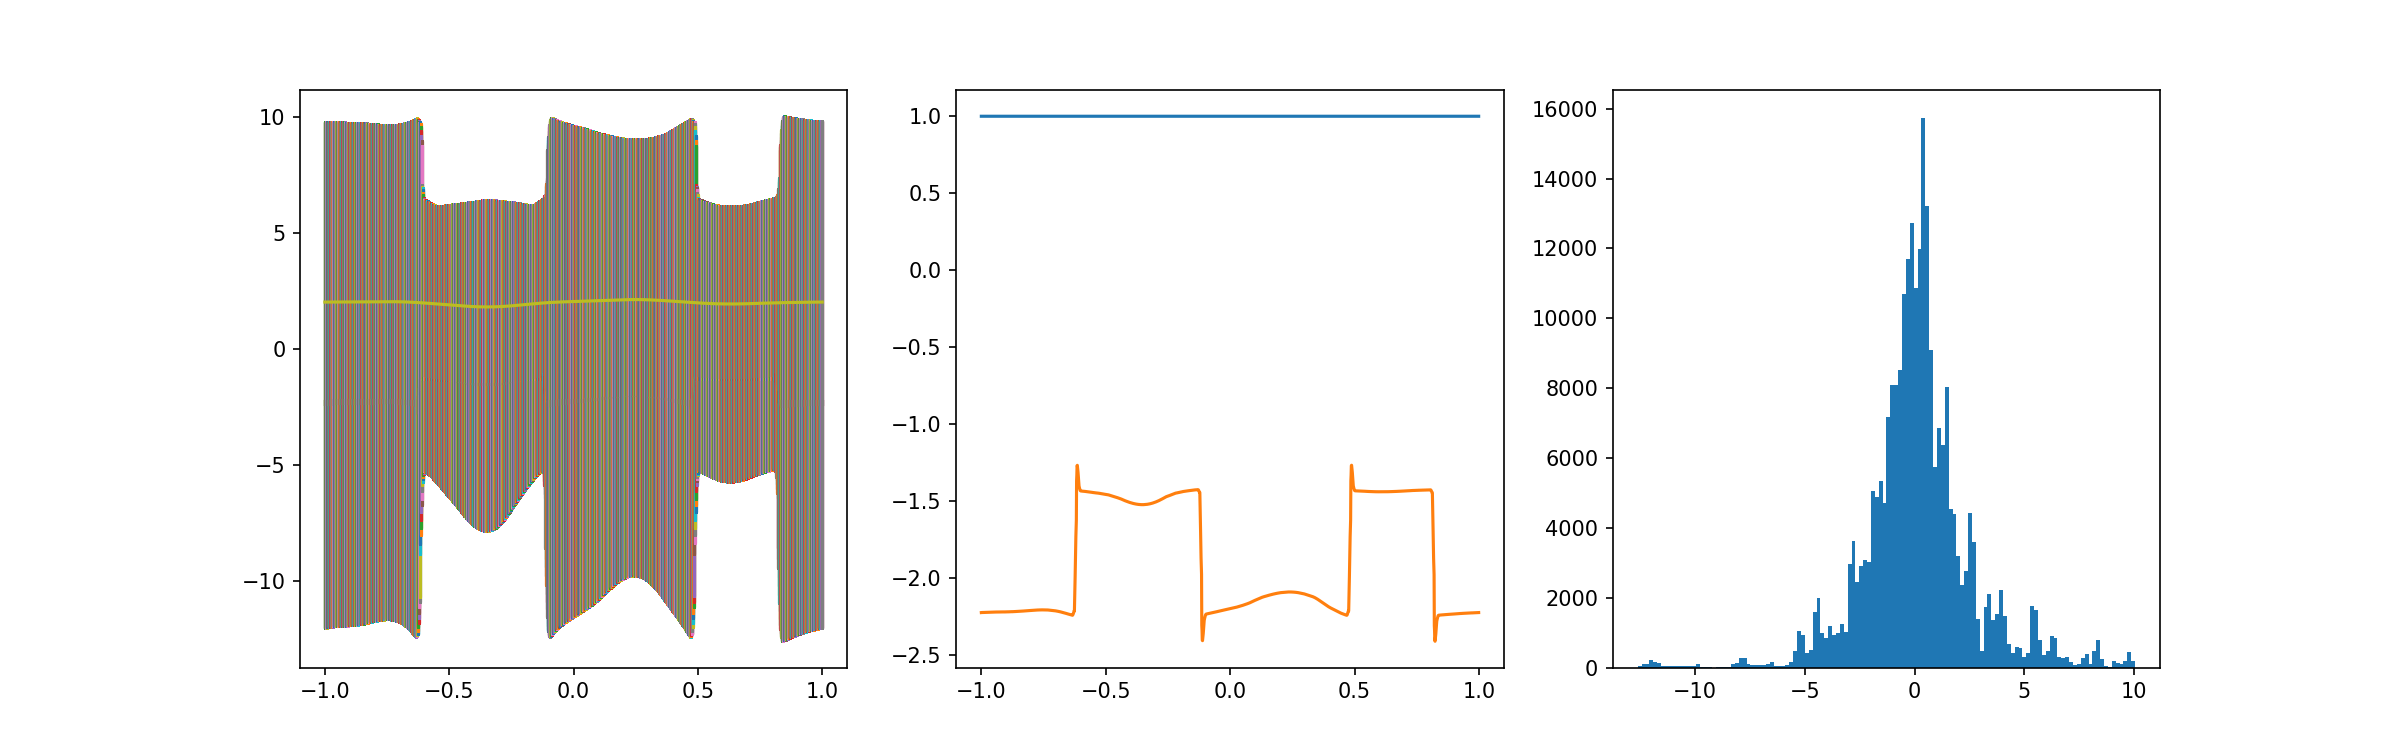

inputfeatures : mean 1, std 0, min 1, max 1
outputFeatures: mean 0.16376, std 2.51465, min -12.6151, max 10.0523


In [97]:
def buildMLP(layers, inputFeatures = 1, gain = 1/np.sqrt(34)):
    modules = []
    if len(layers) > 1:
        for i in range(len(layers) - 1):
            modules.append(nn.Linear(inputFeatures if i == 0 else layers[i-1],layers[i]))
#             torch.nn.init.uniform_(modules[-1].weight,-0.5, 0.5)
            torch.nn.init.xavier_normal_(modules[-1].weight,1)
    #         torch.nn.init.zeros_(modules[-1].weight)
            torch.nn.init.zeros_(modules[-1].bias)
            modules.append(nn.BatchNorm1d(layers[i]))
            modules.append(nn.ReLU())
        modules.append(nn.Linear(layers[-2],layers[-1]))
    else:
        modules.append(nn.Linear(inputFeatures,layers[-1]))        
    torch.nn.init.xavier_normal_(modules[-1].weight,gain)
    torch.nn.init.zeros_(modules[-1].bias)
    return nn.Sequential(*modules)
outFeatures = []
width = 4
depth = 4
nx = 128
for ii in range(nx):    
    MLPmodel = buildMessagePassingNetwork(inputFeatures, feedThroughEdgeFeatures = 0, vertexFeatures = [8,8], vertexMLPLayout = [width] * depth, edgeMLP = False)#, edgeFeatures = [1,2,2])
#     MLPmodel = buildPointNet(inputFeatures, feedThroughVertexFeatures = 0, vertexFeatures = None, vertexMLPLayout = [width] * depth)
#     MLPmodel = buildGNS(inputFeatures, feedThroughVertexFeatures = 0, feedThroughEdgeFeatures = 0, vertexFeatures = None, vertexMLPLayout = [width] * depth, edgeMLP = False, edgeFeatures = [1] + [], messageFeatures = [8])
    featuresOut = MLPmodel(i, j,
                           inputVertexFeatures = features, 
                           inputEdgeFeatures = distance, 
                           feedThroughVertexFeatures = None,
                           feedThroughEdgeFeatures = None, #(u[j] - u[i])[:,None], 
                          )
    outFeatures.append(featuresOut.detach().numpy())
print('Output of GraphNetwork has shape ', featuresOut.shape, 'parameters:', count_parameters(MLPmodel))
MLPmodel.printProcess()

fig, axis = plt.subplots(1, 3, figsize=(16,5), sharex = False, sharey = False, squeeze = False)

axis[0,0].plot(x.repeat(1,nx).mT, np.array(outFeatures)[:,:,0])
axis[0,0].plot(x, groundTruth)
axis[0,1].plot(x, features.detach().numpy())
axis[0,1].plot(x, featuresOut.detach().numpy())
axis[0,2].hist(np.array(outFeatures).flatten(),bins = 128)

print('inputfeatures : mean %g, std %g, min %g, max %g' % (np.mean(features.detach().numpy()), np.std(features.detach().numpy()), np.min(features.detach().numpy()), np.max(features.detach().numpy())))
print('outputFeatures: mean %g, std %g, min %g, max %g' % (np.mean(outFeatures), np.std(outFeatures), np.min(outFeatures), np.max(outFeatures)))

In [98]:
import pandas as pd
seed = 1

In [99]:
import sklearn
import pandas
def signaltonoise_dB(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20*np.log10(abs(np.where(sd == 0, 0, m/sd)))

def getTestingLossFrameMLP(net, testData, plot = False):
#     label = '%s x %2d @ %s' % (modelState['basis'], modelState['n'], str(modelState['layers']))
    testPredictions = {}
    testGTs = {}
    testPositions = {}
    with torch.no_grad():
        for i, k in  enumerate(testData.keys()):
            gt = testData[k][9].reshape(len(testData[k][0]), testData[k][0][0].shape[0])
            prediction = net(testData[k][6], testData[k][7], testData[k][5], testData[k][8], testData[k][-2] if net.feedThroughVertexFeatures != 0 else None, (testData[k][-1][testData[k][7]] - testData[k][-1][testData[k][6]])[:,None] if net.feedThroughEdgeFeatures != 0 else None).reshape(len(testData[k][0]), testData[k][0][0].shape[0]).detach().cpu().numpy()
            testPredictions[k] = prediction
            testGTs[k] = gt.detach().cpu().numpy()
            testPositions[k] = testData[k][0]
    if plot:
        fig, axis = plt.subplots(len(testPredictions.keys()),3, figsize=(16,8), sharex = True, sharey = 'col', squeeze = False)

        for s, k in  enumerate(testData.keys()):
            norm = mpl.colors.Normalize(vmin=0, vmax=len(testPredictions[k]) - 1)
            for i, (xs, rhos) in enumerate(zip(testPositions[k], testGTs[k])):
                c = cmap(norm(i))
                axis[s,0].plot(xs.cpu().numpy(), rhos, ls = '-', c = c)
            for i, (xs, rhos) in enumerate(zip(testPositions[k], testPredictions[k])):
                c = cmap(norm(i))
                axis[s,1].plot(xs.cpu().numpy(), rhos, ls = '-', c = c)
            for i, (xs, pred, gt) in enumerate(zip(testPositions[k], testPredictions[k], testGTs[k])):
                c = cmap(norm(i))
                axis[s,2].plot(xs.cpu().numpy(), pred- gt, ls = '-', c = c)
        axis[0,0].set_title('GT')
        axis[0,1].set_title('Pred')
        axis[0,2].set_title('Loss')
        fig.tight_layout()
        # axis[0,0].plot()
    lossDict = []
    for s, k in  enumerate(testData.keys()):
        lossTerms = []
        for i, (xs, pred, gt) in enumerate(zip(testPositions[k], testPredictions[k], testGTs[k])):
            loss = (pred - gt)**2
            r2 = sklearn.metrics.r2_score(gt, pred)
            l2 = sklearn.metrics.mean_squared_error(gt, pred)

            maxSignal = np.max(np.abs(gt))
    #         mse = np.mean((pred - gt)**2)
            psnr = 20 * math.log10(maxSignal / np.sqrt(l2))
    #         print(20 * math.log10(maxSignal / np.sqrt(mse)))
    #         print(maxSignal, mse)
    #         male = np.mean(np.abs(np.log(np.abs(pred) / np.abs(gt))[gt != 0]))
    #         rmsle = np.sqrt(np.mean(np.log(np.abs(pred) / np.abs(gt))[gt != 0]**2)
            minVal = np.min(loss)
            maxVal = np.max(loss)
            std = np.std(loss)
            q1, q3 = np.percentile(loss, [25, 75])
    #         print('r2', r2, 'l2', l2, 'psnr', l2, 'min', minVal, 'max', maxVal, 'q1', q1, 'q3', q3, 'std', std)
            lossTerms.append({
                    'Vertex': net.vertexMode, 
                    'Edge': net.edgeMode, 
                    'inputEncode': net.inputEncode,
                    'outputDecode': net.outputEncode,
                    'inputEdgeEncode': net.inputEdgeEncode,
                    'vertexFeatures': f"[{' '.join([str(s) for s in net.vertexFeatures])}]",
                    'vertexHiddenLayout': f"[{' '.join([str(s) for s in net.vertexHiddenLayout])}]",
                    'feedThroughVertexFeatures': net.feedThroughVertexFeatures,
                    'edgeMLP': net.edgeMLP,
                    'edgeFeatures': f"[{' '.join([str(s) for s in net.edgeFeatures])}]",
                    'edgeHiddenLayout': f"[{' '.join([str(s) for s in net.edgeHiddenLayout])}]",
                    'feedThroughEdgeFeatures': net.feedThroughEdgeFeatures,
                    'messagelayout': f"[{' '.join([str(s) for s in net.messageFeatures])}]",
                    'parameters': count_parameters(net),
                    'seed': net.seed,
                    'file':k, 'entry':str(i),'r2':r2,'l2':l2,'psnr':psnr, 'min':minVal, 'max':maxVal, 'q1':q1, 'q3':q3, 'std':std})
    #         print(r2, l2, psnr)
    #         print(male, rmsle)
    #         break
        lossDict += lossTerms
    #     break
    return pandas.DataFrame(data = lossDict)

In [100]:

# MLPmodel = buildPointNet(1, feedThroughVertexFeatures = 1, vertexFeatures = None, vertexMLPLayout = [4,4,4])

# getTestingLossFrameMLP(MLPmodel, testData)

In [106]:
def trainMLP(particleData, testData, settings, dataSet, trainingFiles, offset, model, epochs = 5, iterations = 1000, testInterval = 10, initialLR = 1e-2, groundTruthFn = None, featureFn = None, lossFn = None, device = 'cpu'):   
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     np.random.seed(seed)
    
#     windowFn = getWindowFunction(window, norm = windowNorm) if window is not None else None
#     model = mlpNetwork(inputFeatures = fluidFeatures, mlpLayout = mlpLayout, layers = layers).to(device) 
#     model = RbfNet(fluidFeatures = fluidFeatures, 
#                    layers = layers, 
#                    denseLayer = True, activation = 'ReLU', coordinateMapping = 'cartesian', 
#                    n = n, windowFn = windowFn, rbf = basis, batchSize = 32, ignoreCenter = True, normalized = False).to(device)   
    lr = initialLR
#     with torch.no_grad():
#         if weightOverride is not None:
#             model.convs[0].weight[:,0,0] = torch.tensor(weightOverride).to(device)
    
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)
    losses = []
    lossValues = []
    testLosses = {}
    testPredictions = {}
    for e in (pb := tqdm(range(epochs), leave = False)):
        for b in (pbl := tqdm(range(iterations), leave=False)):
            
            try:
                bdata = next(dataIter)
                if len(bdata) < batchSize :
                    raise Exception('batch too short')
            except:
                dataIter = iter(dataLoader)
                bdata = next(dataIter)

            positions, velocities, areas, dudts, density, inputVelocity, outputVelocity, setup = loadBatch(trainingData, settings, dataSet, bdata, device, offset)
            i, j, distance, direction = batchedNeighborsearch(positions, setup)
            x, u, v, rho, dudt, inVel, outVel = flatten(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity)

            x = x[:,None].to(device)    
            groundTruth = groundTruthFn(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity, i, j, distance, direction).to(device)
            distance = (distance * direction)[:,None].to(device)
            features = featureFn(x, u, v, rho, dudt, inVel, outVel).to(device)

            optimizer.zero_grad()
            prediction = model(i,j, features.to(device), distance.to(device), x if model.feedThroughVertexFeatures != 0 else None, (u[j] - u[i])[:,None] if model.feedThroughEdgeFeatures!=0 else None)[:,0]
            lossTerm = lossFn(prediction, groundTruth)
            loss = torch.mean(lossTerm)

            loss.backward()
            optimizer.step()
            losses.append(lossTerm.detach().cpu())
            lossValues.append(loss.detach().cpu().item())

            lossString = np.array2string(torch.mean(lossTerm.reshape(batchSize, positions[0].shape[0]),dim=1).detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.4e" % x})
            batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%6d' % x}))

            pbl.set_description('%s:  %s -> %.4e' %(batchString, lossString, loss.detach().cpu().numpy()))
            pb.set_description('epoch %2dd, lr %6.4g: loss %.4e [rolling %.4e]' % (e, lr, np.mean(lossValues), np.mean(lossValues[-100:] if len(lossValues) > 100 else lossValues)))
            
            it = e * iterations + b
            if it % testInterval == 0:
                with torch.no_grad():
                    testLossDict = {}
                    testPreds = {}
                    for i, k in  enumerate(testData.keys()):
                        gt = testData[k][9].reshape(len(testData[k][0]), testData[k][0][0].shape[0])
                        prediction = model(testData[k][6], testData[k][7], testData[k][5], testData[k][8], testData[k][-2] if model.feedThroughVertexFeatures != 0 else None, (testData[k][-1][testData[k][7]] - testData[k][-1][testData[k][6]])[:,None] if model.feedThroughEdgeFeatures != 0 else None).reshape(len(testData[k][0]), testData[k][0][0].shape[0])
            
#                         prediction = model(testData[k][6], testData[k][7], testData[k][5], testData[k][8]).reshape(len(testData[k][0]), testData[k][0][0].shape[0])
                        arr = []
                        for i, (xs, pred, gt) in enumerate(zip(testData[k][0], prediction, gt)):
                             arr.append(lossFn(pred, gt).detach().cpu().numpy())
                        testLossDict[k] = arr
                        testPreds[k] = prediction.detach().cpu()
#                         print(testLossDict[k])
                    testLosses[it] = testLossDict
                    testPredictions[it] = testPreds
#             break
#         break
        
        lr = lr * 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']
            
    return {'model': model, 'optimizer': optimizer, 'finalLR': lr, 'losses': losses, 'testLosses': testLosses, 'testPredictions': testPredictions, 'seed': model.seed, 'epochs': epochs, 'iterations': iterations}




In [107]:

# # MLPmodel = buildMessagePassingNetwork(inputFeatures, feedThroughEdgeFeatures = 1, vertexFeatures = [2, 2], vertexMLPLayout = [4,4,4], edgeMLP = True, edgeFeatures = [1,2,2])
# # featuresOut = MLPmodel(i, j,
# #                        inputVertexFeatures = features, 
# #                        inputEdgeFeatures = distance, 
# #                        feedThroughVertexFeatures = None,
# #                        feedThroughEdgeFeatures = (u[j] - u[i])[:,None], 
# #                       )
# # print('Output of GraphNetwork has shape ', featuresOut.shape)
# # MLPmodel.printProcess()

# net = buildMessagePassingNetwork(inputFeatures, feedThroughEdgeFeatures = 0, vertexFeatures = None, vertexMLPLayout = l, edgeMLP = False, edgeFeatures = [1], seed = s)
    
# modelstate = trainMLP(particleData, testData, settings, dataSet, trainingFiles, offset, net,
#         epochs = 5, iterations = 1000, initialLR = 1e-3, device = device, testInterval = 100,
#         groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)  


In [108]:
def getGroundTruthKernel(positions, velocities, areas, densities, dudts, inVel, outVel, i, j, distance, direction):
    return scatter_sum(torch.hstack(areas)[j] * kernel(torch.abs(distance), particleSupport), i, dim = 0, dim_size = torch.hstack(areas).shape[0])
def getGroundTruthKernelGradient(positions, velocities, areas, densities, dudts, inVel, outVel, i, j, distance, direction):
    return scatter_sum(torch.hstack(areas)[j] * kernelGradient(torch.abs(distance), direction, particleSupport), i, dim = 0, dim_size = torch.hstack(areas).shape[0])
def getGroundTruthPhysics(positions, velocities, areas, densities, dudts, inVel, outVel, i, j, distance, direction):
    return torch.hstack(outVel)
def getFeaturesKernel(positions, velocities, areas, densities, dudts, inVel, outVel):
    return torch.ones_like(areas )[:,None]
def getFeaturesPhysics(positions, velocities, areas, densities, dudts, inVel, outVel):
    return torch.vstack((inVel, densities,torch.ones_like(areas))).mT

torch.manual_seed('1337')

dataLoader = DataLoader(dataSet, shuffle=True, batch_size = batchSize).batch_sampler
dataIter = iter(dataLoader)

def lossFunction(prediction, groundTruth):
    return (prediction - groundTruth)**2 # MSE

# testData = {}
# for i in range(len(testingFiles)):
#     testData[testingFiles[i].split('/')[-1].split('.')[0]] = loadTestcase(testingData, settings, testingFiles[i], [0], device, getGroundTruth, getFeatures)

# Hyperparameters for the NN
lr = 1e-2 # Learning rate
iterations = 1000 # update iterations per epoch
epochs = 5 # total number of epochs, LR is halved every epoch
# n = 17 # number of weights per continuous convolution
# basis = 'fourier' # basis for the convolution, set to linear for CConv

# window = 'cubicSpline'
# windowNorm = 'integral'
# window = None

layers = [1]
initialLR = 1e-2
particleData = trainingData
# groundTruthFn = getGroundTruth
# featureFn = getFeatures
lossFn = lossFunction

inputFeatures = 1
seeds = np.random.randint(0, 2**30, 4)


testCase = 'kernel'

if testCase == 'kernel':
    groundTruthFn = getGroundTruthKernel
    featureFn = getFeaturesKernel
elif testCase == 'kernelGradient':
    groundTruthFn = getGroundTruthKernelGradient   
    featureFn = getFeaturesKernel 
elif testCase == 'physicsUpdate':
    groundTruthFn = getGroundTruthPhysics
    featureFn = getFeaturesPhysics
    
testData = {}
for i in range(len(testingFiles)):
#     testData[testingFiles[i].split('/')[-1].split('.')[0]] = loadTestcase(testingData, settings, testingFiles[i], [0, 128, 256, 1024], device, getGroundTruth, getFeatures, offset)
    testData['_'.join(testingFiles[i].split('/')[-1].split('.')[0].split('_')[1:3])] = loadTestcase(testingData, settings, testingFiles[i], [offset, 128, 256, 1024], device, groundTruthFn, featureFn, offset)

In [109]:
# net

In [110]:
basis = 'MP-PDE'
widths = [1,4,16,64]
depths = [0,1,2,3,4,5,6,7,8]
messages = [8]

def runAblationStudyMLPOneLayer(basis, testCase, widths, depths, messages):
    global testData
    if testCase == 'kernel':
        groundTruthFn = getGroundTruthKernel
        featureFn = getFeaturesKernel
    elif testCase == 'kernelGradient':
        groundTruthFn = getGroundTruthKernelGradient   
        featureFn = getFeaturesKernel 
    elif testCase == 'physicsUpdate':
        groundTruthFn = getGroundTruthPhysics
        featureFn = getFeaturesPhysics

    testData = {}
    for i in range(len(testingFiles)):
        testData['_'.join(testingFiles[i].split('/')[-1].split('.')[0].split('_')[1:3])] = loadTestcase(testingData, settings, testingFiles[i], [offset, 128, 256, 1024], device, groundTruthFn, featureFn, offset)
        
    layouts = []
    for d in depths:
        for w in widths:
            l = [w] * d
            if l not in layouts:
                layouts.append(l)
#     print(len(messages) * len(seeds) * len(layouts))

    dataset = pandas.DataFrame()
    for l in tqdm(layouts, leave = False):
        for m in tqdm(messages, leave = False):
            for s in tqdm(seeds, leave = False):
                if basis == 'PointNet':
                    net = buildPointNet(inputFeatures, feedThroughVertexFeatures = 1, vertexFeatures = None, vertexMLPLayout = l, seed = s)
                if basis == 'DPCConv':
                    net = buildMessagePassingNetwork(inputFeatures, feedThroughEdgeFeatures = 0, vertexFeatures = None, vertexMLPLayout = l, edgeMLP = False, edgeFeatures = [1], seed = s)
                if basis == 'GNS':
                    net = buildGNS(inputFeatures, feedThroughVertexFeatures = 0, feedThroughEdgeFeatures = 0, vertexFeatures = None, vertexMLPLayout = l, edgeMLP = False, edgeFeatures = [1] + [], messageFeatures = [m], seed = s)
                if basis == 'MP-PDE':
                    net = buildGNS(inputFeatures, feedThroughVertexFeatures = 1, feedThroughEdgeFeatures = 1, vertexFeatures = None, vertexMLPLayout = l, edgeMLP = False, edgeFeatures = [1] + [], messageFeatures = [m], seed = s)

                modelstate = trainMLP(particleData, testData, settings, dataSet, trainingFiles, offset, net,
                    epochs = 5, iterations = 1000, initialLR = 1e-3, device = device, testInterval = 100,
                    groundTruthFn = groundTruthFn, featureFn = featureFn, lossFn = lossFunction)  
                df = getTestingLossFrameMLP(net, testData)

                dataset = pandas.concat([dataset, df])


                dataset.to_csv('ablationStudy_%s_%s ws %s ds %s seeds %s messsages %s.csv' % (testCase, basis, '[' + ' '.join([str(d) for d in widths]) + ']', '[' + ' '.join([str(d) for d in depths]) + ']', '[' + ' '.join([str(d) for d in seeds]) + ']','[' + ' '.join([str(d) for d in messages]) + ']'))


In [ ]:
widths = [1,4,16,64]
depths = [0,1,2,3,4,5,6,7,8]
messages = [8]
runAblationStudyMLPOneLayer('DPCConv', 'kernel', widths, depths, messages)


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
widths = [1,4,16,64]
depths = [0,1,2,3,4,5,6,7,8]
messages = [8]

for basis in tqdm(['PointNet', 'DPCConv', 'GNS', 'MP-PDE']):
    for testCase in tqdm(['kernel', 'kernelGradient'], leave = False):                
        runAblationStudyMLPOneLayer(basis, testCase, widths, depths, messages)

In [ ]:
ns = [1,2,3,4,5,6,7,8,16,32]
widths = [1][::-1]
depths = [0][::-1]                
for basis in tqdm(['fourier odd', 'dmcf', 'abf cubic_spline', 'fourier even', 'linear', 'ffourier', 'chebyshev', 'rbf square']):
    for window in tqdm([None, 'poly6'], leave = False):
        for testCase in tqdm(['kernel', 'kernelGradient'], leave = False):          
            trainRBFNetwork(basis, testCase, ns, widths, depths, window)

In [ ]:
display(dataset)
cdata = copy.deepcopy(dataset).reset_index()

In [ ]:
display(int(cdata['vertexHiddenLayout'][0][1:-1].split(' ')[0]) if cdata['vertexHiddenLayout'][0] != '[]' else 0)

In [ ]:
processedData = pd.DataFrame()

for e in tqdm(cdata.index):
    processedData = pd.concat([processedData, pd.DataFrame({
        'Vertex': cdata['Vertex'][e],
        'Edge': cdata['Edge'][e],
        'Layout': cdata['vertexHiddenLayout'][e],
        'Width': int(cdata['vertexHiddenLayout'][e][1:-1].split(' ')[0]) if cdata['vertexHiddenLayout'][e] != '[]' else 0,
        'Depth': len(cdata['vertexHiddenLayout'][e][1:-1].split(' ')),
        'Parameters': cdata['parameters'][e],
        'Metric': 'PSNR',
        'Value': cdata['psnr'][e],
        'Seed': cdata['seed'][e],
        'File': cdata['file'][e],
        'Messages': cdata['messagelayout'][e][1:-1].split(' ')[0],
        'Entry': cdata['entry'][e]
        },index=[0])], ignore_index=True)
    processedData = pd.concat([processedData, pd.DataFrame({
        'Vertex': cdata['Vertex'][e],
        'Edge': cdata['Edge'][e],
        'Layout': cdata['vertexHiddenLayout'][e],
        'Width': int(cdata['vertexHiddenLayout'][e][1:-1].split(' ')[0]) if cdata['vertexHiddenLayout'][e] != '[]' else 0,
        'Depth': len(cdata['vertexHiddenLayout'][e][1:-1].split(' ')),
        'Parameters': cdata['parameters'][e],
        'Metric': 'r2',
        'Value': cdata['r2'][e],
        'Seed': cdata['seed'][e],
        'File': cdata['file'][e],
        'Messages': cdata['messagelayout'][e][1:-1].split(' ')[0],
        'Entry': cdata['entry'][e]
        },index=[0])], ignore_index=True)
    processedData = pd.concat([processedData, pd.DataFrame({
        'Vertex': cdata['Vertex'][e],
        'Edge': cdata['Edge'][e],
        'Layout': cdata['vertexHiddenLayout'][e],
        'Width': int(cdata['vertexHiddenLayout'][e][1:-1].split(' ')[0]) if cdata['vertexHiddenLayout'][e] != '[]' else 0,
        'Depth': len(cdata['vertexHiddenLayout'][e][1:-1].split(' ')),
        'Parameters': cdata['parameters'][e],
        'Metric': 'L2',
        'Value': cdata['l2'][e],
        'Seed': cdata['seed'][e],
        'File': cdata['file'][e],
        'Messages': cdata['messagelayout'][e][1:-1].split(' ')[0],
        'Entry': cdata['entry'][e]
        },index=[0])], ignore_index=True)
#     display(processedData)
#     break
processedData['Parameters'] = processedData['Parameters'].astype(int)
processedData['Depth'] = processedData['Depth'].astype(str)
processedData['Width'] = processedData['Width'].astype(str)
display(processedData)

In [ ]:
cdata.keys()

In [ ]:
g = sns.relplot(x = 'Parameters', y = 'Value', hue = 'Depth', col = 'Metric', data = processedData, row = 'Messages',
                kind = 'line', errorbar = ('pi',70), height = 4, 
#                 hue_order = ['CConv','SplineConv','DMCF', 'Fourier', 'Fourier (even)', 'Chebyshev'],
                facet_kws = {'sharey':False},
                col_order = ['L2', 'PSNR'], aspect = 1.5)
g.set_axis_labels('n','')
# g.axes[0,0].set_title('PSNR')
# g.axes[0,1].set_title('R2')
g.axes[0,0].set_yscale('log')
g.set_titles('{col_name} | {row_name}')
g.despine(left=False)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Density Interpolation Ablation Study')
g.axes[0,0].set_xscale('log')
# g.axes[0,0].set_xlim(2, 2**16)

In [ ]:
g = sns.catplot(x = 'Width', y = 'Value', hue = 'Depth', col = 'Metric', data = processedData, row = 'Messages',
                kind = 'bar', errorbar = ('pi',70), height = 4, 
#                 hue_order = ['CConv','SplineConv','DMCF', 'Fourier', 'Fourier (even)', 'Chebyshev'],
                facet_kws = {'sharey':False},
                col_order = ['L2', 'PSNR'], aspect = 1.5, sharey = False)
# g.set_axis_labels('n','')
# # g.axes[0,0].set_title('PSNR')
# # g.axes[0,1].set_title('R2')
g.axes[0,0].set_yscale('log')
# g.set_titles('{col_name} | {row_name}')
# g.despine(left=False)
# g.fig.subplots_adjust(top=0.8)
# g.fig.suptitle('Density Interpolation Ablation Study')
# g.axes[0,0].set_xscale('log')
# g.axes[0,0].set_xlim(2, 2**16)

In [ ]:
basis = 'rbf square'


ns = [1,2,3,4,5,6,7,8,16,32]
# ns = [4]
widths = [1][::-1]
depths = [0][::-1]
# widths = [16]
# depths = [3]

layouts = []
for d in depths:
    for w in widths:
        l = [w] * d + [1]
        if l not in layouts:
#             print([w] * d + [1])
            layouts.append(l)
# print(layouts)
# print(len(layouts) * len(seeds) * len(ns))
dataset = pandas.DataFrame()
# models = []

for basis in tqdm(bases, leave = False):
    dataset = pandas.DataFrame()
    for n in tqdm(ns, leave = False):
        for l in tqdm(layouts, leave = False):
            for s in tqdm(seeds, leave = False):
                trainedModel = trainModel(particleData, testData, settings, dataSet, trainingFiles, fluidFeatures = 1, offset = offset,
                                  n = n, basis = basis, layers = l, seed = s,
                                 window = window, windowNorm = windowNorm,
                                 epochs = 5, iterations = 1000, initialLR = 1e-3, device = device, testInterval = 1000,
                                 groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
        #         models.append(trainedModel)
                df = getTestingLossFrame(trainedModel, testData, plot = False)
                dataset = pandas.concat([dataset, df])
                dataset.to_csv('ablationStudy_densityGradient_%s ns %s ws %s ds %s seeds %s.csv' % (basis, '[' + ' '.join([str(d) for d in ns]) + ']', '[' + ' '.join([str(d) for d in widths]) + ']', '[' + ' '.join([str(d) for d in depths]) + ']', '[' + ' '.join([str(d) for d in seeds]) + ']'))
                


In [ ]:
positions, velocities, areas, dudts, density, inputVelocity, outputVelocity, setup = loadBatch(trainingData, settings, dataSet, bdata, device, offset)
i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, rho, dudt, inVel, outVel = flatten(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity)

x = x[:,None].to(device)    
groundTruth = groundTruthFn(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity, i, j, distance, direction).to(device)
distance = (distance * direction)[:,None].to(device)
features = featureFn(x, u, v, rho, dudt, inVel, outVel).to(device)

MLPmodel.train()
optimizerMLP.zero_grad()
featuresOut = MLPmodel(features, i, j, distance)
print(features, featuresOut)

print(featuresOut,groundTruth)
diff = torch.mean((features - featuresOut)**2)
diff.backward()
# print(list(MLPmodel.parameters())[0], list(MLPmodel.parameters())[0].grad)

In [ ]:
fig, axis = plt.subplots(1,1, figsize=(12,8), sharex = True, sharey = False, squeeze = False)

xSynthetic, featuresSynthetic, iSynthetic, jSynthetic = generateSyntheticData(511, device)

# if modelState['fluidFeatures'] == 1:
modelSynth = MLPmodel(featuresSynthetic , iSynthetic, jSynthetic, xSynthetic).detach().cpu().numpy()
#         print(np.min(modelSynth))
#         print(np.max(modelSynth))
axis[0,0].plot(xSynthetic[:,0].detach().cpu().numpy(), modelSynth, ls='-',c= 'green', alpha = 0.95)
#         axis['F'].plot(xSynthetic[:,0].detach().cpu().numpy(), baseArea * kernel(torch.abs(xSynthetic), particleSupport).detach().cpu().numpy(), c = 'blue')
fxBase = baseArea * kernelGradient(torch.abs(xSynthetic), torch.sign(xSynthetic), particleSupport).detach().cpu().numpy()
#         print(np.min(fxBase))
#         print(np.max(fxBase))
axis[0,0].plot(xSynthetic[:,0].detach().cpu().numpy(), fxBase, c = 'red')
axis[0,0].set_title('convolution operator')
axis[0,0].axhline(0, ls = '--', c = 'black')


In [ ]:
list(MLPmodel.parameters())

In [ ]:
features.shape

In [ ]:
def trainMLP(particleData, testData, settings, dataSet, trainingFiles, offset, seed, mlpLayout = [8,8,8,8,1], fluidFeatures = 1, n = 16, basis = 'linear', layers = [1], window = None, windowNorm = None, epochs = 5, iterations = 1000, testInterval = 10, initialLR = 1e-2, groundTruthFn = None, featureFn = None, lossFn = None, device = 'cpu', weightOverride = None):   
#     random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
    windowFn = getWindowFunction(window, norm = windowNorm) if window is not None else None
    model = mlpNetwork(inputFeatures = fluidFeatures, mlpLayout = mlpLayout, layers = layers).to(device) 
#     model = RbfNet(fluidFeatures = fluidFeatures, 
#                    layers = layers, 
#                    denseLayer = True, activation = 'ReLU', coordinateMapping = 'cartesian', 
#                    n = n, windowFn = windowFn, rbf = basis, batchSize = 32, ignoreCenter = True, normalized = False).to(device)   
    lr = initialLR
    with torch.no_grad():
        if weightOverride is not None:
            model.convs[0].weight[:,0,0] = torch.tensor(weightOverride).to(device)
    
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)
    losses = []
    lossValues = []
    testLosses = {}
    testPredictions = {}
    for e in (pb := tqdm(range(epochs), leave = False)):
        for b in (pbl := tqdm(range(iterations), leave=False)):
            
            try:
                bdata = next(dataIter)
                if len(bdata) < batchSize :
                    raise Exception('batch too short')
            except:
                dataIter = iter(dataLoader)
                bdata = next(dataIter)

            positions, velocities, areas, dudts, density, inputVelocity, outputVelocity, setup = loadBatch(trainingData, settings, dataSet, bdata, device, offset)
            i, j, distance, direction = batchedNeighborsearch(positions, setup)
            x, u, v, rho, dudt, inVel, outVel = flatten(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity)

            x = x[:,None].to(device)    
            groundTruth = groundTruthFn(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity, i, j, distance, direction).to(device)
            distance = (distance * direction)[:,None].to(device)
            features = featureFn(x, u, v, rho, dudt, inVel, outVel).to(device)

            optimizer.zero_grad()
            prediction = model(features.to(device), i.to(device), j.to(device), distance.to(device))[:,0]
            lossTerm = lossFn(prediction, groundTruth)
            loss = torch.mean(lossTerm)

            loss.backward()
            optimizer.step()
            losses.append(lossTerm.detach().cpu())
            lossValues.append(loss.detach().cpu().item())

            lossString = np.array2string(torch.mean(lossTerm.reshape(batchSize, positions[0].shape[0]),dim=1).detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.4e" % x})
            batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%6d' % x}))

            pbl.set_description('%s:  %s -> %.4e' %(batchString, lossString, loss.detach().cpu().numpy()))
            pb.set_description('epoch %2dd, lr %6.4g: loss %.4e [rolling %.4e]' % (e, lr, np.mean(lossValues), np.mean(lossValues[-100:] if len(lossValues) > 100 else lossValues)))
            
            it = e * iterations + b
            if it % testInterval == 0:
                with torch.no_grad():
                    testLossDict = {}
                    testPreds = {}
                    for i, k in  enumerate(testData.keys()):
                        gt = testData[k][9].reshape(len(testData[k][0]), testData[k][0][0].shape[0])
                        prediction = model(testData[k][5], testData[k][6], testData[k][7], testData[k][8]).reshape(len(testData[k][0]), testData[k][0][0].shape[0])
                        arr = []
                        for i, (xs, pred, gt) in enumerate(zip(testData[k][0], prediction, gt)):
                             arr.append(lossFn(pred, gt).detach().cpu().numpy())
                        testLossDict[k] = arr
                        testPreds[k] = prediction.detach().cpu()
#                         print(testLossDict[k])
                    testLosses[it] = testLossDict
                    testPredictions[it] = testPreds
#             break
#         break
        
        lr = lr * 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']
            
    return {'model': model, 'optimizer': optimizer, 'finalLR': lr, 'losses': losses, 'testLosses': testLosses, 'testPredictions': testPredictions, 'seed': seed,
            'window': window, 'windowNorm': windowNorm, 'n':n, 'basis':basis, 'layers':layers, 'epochs': epochs, 'iterations': iterations, 'fluidFeatures': fluidFeatures          
           }

In [ ]:
from scipy.optimize import minimize
nTerms = 4
nEval = 1023

x = np.ones(nTerms)
xvals = np.linspace(-1,1,nEval)
baseTerms = np.sin(xvals[:,None] * np.pi * (np.arange(len(x)) + 1))
terms = (x * baseTerms).T

fx = lambda x: baseArea * kernelGradient(np.abs(x), np.sign(x), particleSupport) * particleSupport
fvals = fx(np.linspace(-1,1,nEval))

error = lambda r: np.mean((fvals - np.sum((r * baseTerms).T, axis = 0))**2)
res = minimize(error, x, method="nelder-mead", options = {'disp': True, 'maxiter': 2**20, 'maxfev': 2**20})  
display(res)
# print(error(res.x))

In [ ]:
fig, axis = plt.subplots(3,1, figsize=(12,8), sharex = True, sharey = False, squeeze = False)
axis[0,0].plot(np.linspace(-1,1,nEval), fx(np.linspace(-1,1,nEval)))
terms = (res.x * baseTerms).T
axis[1,0].plot(xvals, np.sum(terms, axis = 0))
axis[0,0].axvline(0, ls = '--', c = 'black')
axis[0,0].axhline(0, ls = '--', c = 'black')
axis[1,0].axvline(0, ls = '--', c = 'black')
axis[1,0].axhline(0, ls = '--', c = 'black')

axis[2,0].plot(xvals, (np.sum(terms, axis = 0) - fx(np.linspace(-1,1,nEval)))**2 )

print(np.min(fx(np.linspace(-1,1,nEval))))
print(np.max(fx(np.linspace(-1,1,nEval))))

print(res.x)

axis[0,0].set_title('Ground Truth')
axis[1,0].set_title('Approximation')
axis[2,0].set_title('Loss')

# axis[3,0].semilogy(np.abs(res.x))
fig.tight_layout()

In [ ]:
n = 4

In [ ]:
# with torch.no_grad():
#     torch.nn.init.uniform

In [ ]:
basis = 'ffourier'
basis = 'linear'
basis = 'fourier'

In [ ]:
seeds = np.random.randint(0, 2**30, 4)

In [ ]:
os.environ["PYTORCH_NVFUSER_DISABLE"] = 'fallback'
os.environ["PYTORCH_JIT_LOG_LEVEL"] = 'manager.cpp'
#  export PYTORCH_JIT_LOG_LEVEL=manager.cpp`

In [ ]:
[0] + res.x.tolist()

In [ ]:
trainMLP
basis = 'MLP'
window = 'cubicSpline'
window = None
windowFn = getWindowFunction(window)
n = 5
trainedModel = trainMLP(particleData, testData, settings, dataSet, trainingFiles, fluidFeatures = 1, offset = offset, mlpLayout = [16,16,16,16,1],
                          n = n, basis = basis, layers = [1], seed = seeds[0],
                         window = window, windowNorm = windowNorm,
                         epochs = 5, iterations = 1000, initialLR = 1e-3, device = device, testInterval = 100,
#                          groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction, weightOverride = [0] + (res.x * np.sqrt(np.pi)).tolist())
                         groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
# plotModel(trainedModel, testData, device, baseArea, particleSupport)
# plotTrainedBatch(trainingData, settings, dataSet, bdata, device, offset, trainedModel, groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
df = getTestingLossFrame(trainedModel, testData, plot = True)
display(df)

In [ ]:

plotModel(trainedModel, testData, device, baseArea, particleSupport)

In [ ]:
widths = [1,2,4,8,16,32]
depths = [1,2,3,4,5,6,7]

In [ ]:
basis = 'MLP'
# ns = [1,2,3,4,5,6,7,8,16,32]
# ns = [4]
widths = [1,2,4,6,8,12,16,24,32][::-1]
depths = [1,2,3,4,5,6,7][::-1]
# widths = [16]
# depths = [3]

layouts = []
for d in depths:
    for w in widths:
        l = [w] * d + [1]
        if l not in layouts:
#             print([w] * d + [1])
            layouts.append(l)
# print(layouts)
# print(len(layouts) * len(seeds) * len(ns))
dataset = pandas.DataFrame()
# models = []
# print(len(layouts), layouts)


# for n in tqdm(ns, leave = False):
for l in tqdm(layouts, leave = False):
    for s in tqdm(seeds, leave = False):
        trainedModel = trainMLP(particleData, testData, settings, dataSet, trainingFiles, fluidFeatures = 1, offset = offset, mlpLayout = l,
                          n = n, basis = basis, layers = [1], seed = s,
                         window = window, windowNorm = windowNorm,
                         epochs = 5, iterations = 1000, initialLR = 1e-3, device = device, testInterval = 1000,
                         groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
#         models.append(trainedModel)
        df = getTestingLossFrame(trainedModel, testData, plot = False)
        dataset = pandas.concat([dataset, df])
        dataset.to_csv('ablationStudy_density_%s ns %s ws %s ds %s seeds %s.csv' % (basis, '[' + ' '.join([str(d) for d in ns]) + ']', '[' + ' '.join([str(d) for d in widths]) + ']', '[' + ' '.join([str(d) for d in depths]) + ']', '[' + ' '.join([str(d) for d in seeds]) + ']'))

In [ ]:
basis = 'fourier'
window = 'cubicSpline'
window = None
windowFn = getWindowFunction(window)
n = 5
trainedModel = trainModel(particleData, testData, settings, dataSet, trainingFiles, fluidFeatures = 1, offset = offset,
                          n = n, basis = basis, layers = [1], seed = seeds[0],
                         window = window, windowNorm = windowNorm,
                         epochs = 5, iterations = 1000, initialLR = 1e-3, device = device, testInterval = 100,
#                          groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction, weightOverride = [0] + (res.x * np.sqrt(np.pi)).tolist())
                         groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
# plotModel(trainedModel, testData, device, baseArea, particleSupport)
# plotTrainedBatch(trainingData, settings, dataSet, bdata, device, offset, trainedModel, groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
df = getTestingLossFrame(trainedModel, testData, plot = True)
# display(df)
plotModel(trainedModel, testData, device, baseArea, particleSupport)

In [ ]:
# with torch.no_grad():
#     trainedModel['model'].convs[0].weight[:,0,0] = torch.tensor([0] + (res.x * np.sqrt(np.pi)).tolist()).to(device)
#     print(trainedModel['model'].convs[0].weight[:,0,0])
# df = getTestingLossFrame(trainedModel, testData, plot = True)
# display(df)

In [ ]:
# plotModel(trainedModel, testData, device, baseArea, particleSupport)
# plotTrainedBatch(trainingData, settings, dataSet, bdata, device, offset, trainedModel, groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)

In [ ]:
def plotModel(modelState, testData, device, baseArea, particleSupport):
    if modelState['fluidFeatures'] == 1:
        fig, axis = plt.subplot_mosaic('''ABC
        FGH
        DDD''', figsize=(12,6), sharex = False)
    else:
        fig, axis = plt.subplot_mosaic('''ABC
        AGH
        DDD''', figsize=(12,6), sharex = False)

    xSynthetic, featuresSynthetic, iSynthetic, jSynthetic = generateSyntheticData(511, device)

    steps = modelState['iterations'] * modelState['epochs']
    ls = np.logspace(0, np.log10(steps), num =  50)
    ls = [int(np.floor(f)) for f in ls]
    ls = np.unique(ls).tolist()

    if modelState['fluidFeatures'] == 1:
        modelSynth = modelState['model'](featuresSynthetic , iSynthetic, jSynthetic, xSynthetic).detach().cpu().numpy()
#         print(np.min(modelSynth))
#         print(np.max(modelSynth))
        axis['F'].plot(xSynthetic[:,0].detach().cpu().numpy(), modelSynth, ls='-',c= 'green', alpha = 0.95)
#         axis['F'].plot(xSynthetic[:,0].detach().cpu().numpy(), baseArea * kernel(torch.abs(xSynthetic), particleSupport).detach().cpu().numpy(), c = 'blue')
        fxBase = baseArea * kernelGradient(torch.abs(xSynthetic), torch.sign(xSynthetic), particleSupport).detach().cpu().numpy()
#         print(np.min(fxBase))
#         print(np.max(fxBase))
        axis['F'].plot(xSynthetic[:,0].detach().cpu().numpy(), fxBase, c = 'red')
        axis['F'].set_title('convolution operator')

    axis['A'].loglog(torch.mean(torch.vstack(modelState['losses']), dim = 1), ls = '-', c = 'black')
    axis['A'].loglog(torch.min(torch.vstack(modelState['losses']), dim = 1)[0], ls = '--', c = 'black')
    axis['A'].loglog(torch.max(torch.vstack(modelState['losses']), dim = 1)[0], ls = '--', c = 'black')
    axis['A'].set_title('Loss Curve')
    with torch.no_grad():
        for i, k in  enumerate(testData.keys()):
            ax = axis['B']
            if i == 0:
                ax = axis['B']
            if i == 1:
                ax = axis['C']
            if i == 2:
                ax = axis['G']
            if i == 3:
                ax = axis['H']    
            norm = mpl.colors.Normalize(vmin=0, vmax=len(testData[k][0]) - 1)
            gt = testData[k][9].reshape(len(testData[k][0]), testData[k][0][0].shape[0])
            for i, (xs, rhos) in enumerate(zip(testData[k][0], gt)):
                c = cmap(norm(i))
                ax.plot(xs.cpu().numpy(), rhos.cpu().numpy(), c = c)
            prediction = modelState['model'](testData[k][5], testData[k][6], testData[k][7], testData[k][8]).reshape(len(testData[k][0]), testData[k][0][0].shape[0]).detach().cpu().numpy()
            for i, (xs, rhos) in enumerate(zip(testData[k][0], prediction)):
                c = cmap(norm(i))
                ax.plot(xs.cpu().numpy(), rhos, ls = '--', c = c)

            ax.set_title(k)

    def plot(fig, axis, mat, title, cmap = 'viridis', norm = 'linear'):
        im = axis.imshow(mat, cmap = cmap, norm = norm)
        axis.axis('auto')
        ax1_divider = make_axes_locatable(axis)
        cax1 = ax1_divider.append_axes("right", size="1%", pad="1%")
        cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
        cb1.ax.tick_params(labelsize=8) 
        axis.set_title(title)

    lMat = torch.vstack(modelState['losses']).mT
    plot(fig, axis['D'],lMat, title = 'Losses', norm = LogNorm(vmin=torch.min(lMat[lMat> 0]), vmax=torch.max(lMat)))
    fig.suptitle('basis %s @ %2d terms, window: %s [%s]' % (modelState['basis'], modelState['n'], modelState['window'] if modelState['window'] is not None else 'None', modelState['windowNorm'] if modelState['windowNorm'] is not None else 'None'))
    fig.tight_layout()

In [ ]:
window = 'poly6'
window = None
windowFn = getWindowFunction(window)

In [ ]:
bases = ['fourier', 'fourier even', 'fourier odd', 'chebyshev', 'abf cubic_spline', 'linear', 'dmcf']

In [ ]:
basis = 'rbf square'


ns = [1,2,3,4,5,6,7,8,16,32]
# ns = [4]
widths = [1][::-1]
depths = [0][::-1]
# widths = [16]
# depths = [3]

layouts = []
for d in depths:
    for w in widths:
        l = [w] * d + [1]
        if l not in layouts:
#             print([w] * d + [1])
            layouts.append(l)
# print(layouts)
# print(len(layouts) * len(seeds) * len(ns))
dataset = pandas.DataFrame()
# models = []

for basis in tqdm(bases, leave = False):
    dataset = pandas.DataFrame()
    for n in tqdm(ns, leave = False):
        for l in tqdm(layouts, leave = False):
            for s in tqdm(seeds, leave = False):
                trainedModel = trainModel(particleData, testData, settings, dataSet, trainingFiles, fluidFeatures = 1, offset = offset,
                                  n = n, basis = basis, layers = l, seed = s,
                                 window = window, windowNorm = windowNorm,
                                 epochs = 5, iterations = 1000, initialLR = 1e-3, device = device, testInterval = 1000,
                                 groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
        #         models.append(trainedModel)
                df = getTestingLossFrame(trainedModel, testData, plot = False)
                dataset = pandas.concat([dataset, df])
                dataset.to_csv('ablationStudy_densityGradient_%s ns %s ws %s ds %s seeds %s.csv' % (basis, '[' + ' '.join([str(d) for d in ns]) + ']', '[' + ' '.join([str(d) for d in widths]) + ']', '[' + ' '.join([str(d) for d in depths]) + ']', '[' + ' '.join([str(d) for d in seeds]) + ']'))

In [ ]:
basis = 'fourier odd'
ns = [1,2,3,4,5,6,7,8,16,32]
# ns = [4]
widths = [1][::-1]
depths = [0][::-1]
# widths = [16]
# depths = [3]

layouts = []
for d in depths:
    for w in widths:
        l = [w] * d + [1]
        if l not in layouts:
#             print([w] * d + [1])
            layouts.append(l)
# print(layouts)
# print(len(layouts) * len(seeds) * len(ns))
dataset = pandas.DataFrame()
# models = []


for n in tqdm(ns, leave = False):
    for l in tqdm(layouts, leave = False):
        for s in tqdm(seeds, leave = False):
            trainedModel = trainModel(particleData, testData, settings, dataSet, trainingFiles, fluidFeatures = 1, offset = offset,
                              n = n, basis = basis, layers = l, seed = s,
                             window = window, windowNorm = windowNorm,
                             epochs = 5, iterations = 1000, initialLR = 1e-3, device = device, testInterval = 1000,
                             groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
    #         models.append(trainedModel)
            df = getTestingLossFrame(trainedModel, testData, plot = False)
            dataset = pandas.concat([dataset, df])
            dataset.to_csv('ablationStudy_density_%s ns %s ws %s ds %s seeds %s.csv' % (basis, '[' + ' '.join([str(d) for d in ns]) + ']', '[' + ' '.join([str(d) for d in widths]) + ']', '[' + ' '.join([str(d) for d in depths]) + ']', '[' + ' '.join([str(d) for d in seeds]) + ']'))

In [ ]:
basis = 'chebyshev'
ns = [1,2,3,4,5,6,7,8,16,32]
# ns = [4]
widths = [1][::-1]
depths = [0][::-1]
# widths = [16]
# depths = [3]

layouts = []
for d in depths:
    for w in widths:
        l = [w] * d + [1]
        if l not in layouts:
#             print([w] * d + [1])
            layouts.append(l)
# print(layouts)
# print(len(layouts) * len(seeds) * len(ns))
dataset = pandas.DataFrame()
# models = []


for n in tqdm(ns, leave = False):
    for l in tqdm(layouts, leave = False):
        for s in tqdm(seeds, leave = False):
            trainedModel = trainModel(particleData, testData, settings, dataSet, trainingFiles, fluidFeatures = 1, offset = offset,
                              n = n, basis = basis, layers = l, seed = s,
                             window = window, windowNorm = windowNorm,
                             epochs = 5, iterations = 1000, initialLR = 1e-3, device = device, testInterval = 1000,
                             groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
    #         models.append(trainedModel)
            df = getTestingLossFrame(trainedModel, testData, plot = False)
            dataset = pandas.concat([dataset, df])
            dataset.to_csv('ablationStudy_density_%s ns %s ws %s ds %s seeds %s.csv' % (basis, '[' + ' '.join([str(d) for d in ns]) + ']', '[' + ' '.join([str(d) for d in widths]) + ']', '[' + ' '.join([str(d) for d in depths]) + ']', '[' + ' '.join([str(d) for d in seeds]) + ']'))

In [ ]:
dataset = pandas.DataFrame()
for trainedModel in models:
    df = getTestingLossFrame(trainedModel, testData, plot = False)
    dataset = pandas.concat([dataset, df])
display(dataset.groupby(['label']).mean(numeric_only = True))

fig, axis = plt.subplots(4,1, figsize=(12,12), sharex = True, sharey = False, squeeze = False)

dataset.boxplot(column = ['l2', 'psnr', 'r2', 'max'], by = ['n','params','width','depth'], ax = axis, layout=(4,1),figsize=(18,12))
# dataset.boxplot(column = ['l2', 'psnr', 'r2', 'max'], by = ['params'], ax = axis, layout=(4,1),figsize=(18,12))
# axis[0,0].set_xticks(axis[1,0].get_xticks(), axis[1,0].get_xticklabels(), rotation=45, ha='right')
axis[3,0].set_xticks(axis[3,0].get_xticks(), axis[3,0].get_xticklabels(), rotation=45, ha='right')
axis[0,0].set_yscale('log')
# axis[1,0].set_yscale('log')
axis[3,0].set_yscale('log')
fig.suptitle('Test for number of base functions')
fig.tight_layout()

In [ ]:
dataset = pandas.DataFrame()
for trainedModel in models:
    df = getTestingLossFrame(trainedModel, testData, plot = False)
    dataset = pandas.concat([dataset, df])
display(dataset.groupby(['label']).mean(numeric_only = True))

fig, axis = plt.subplots(4,1, figsize=(12,12), sharex = True, sharey = False, squeeze = False)

dataset.boxplot(column = ['l2', 'psnr', 'r2', 'max'], by = ['n','params','width','depth'], ax = axis, layout=(4,1),figsize=(18,12))
# dataset.boxplot(column = ['l2', 'psnr', 'r2', 'max'], by = ['params'], ax = axis, layout=(4,1),figsize=(18,12))
# axis[0,0].set_xticks(axis[1,0].get_xticks(), axis[1,0].get_xticklabels(), rotation=45, ha='right')
axis[3,0].set_xticks(axis[3,0].get_xticks(), axis[3,0].get_xticklabels(), rotation=45, ha='right')
axis[0,0].set_yscale('log')
# axis[1,0].set_yscale('log')
axis[3,0].set_yscale('log')
fig.suptitle('Test for number of base functions')
fig.tight_layout()

In [ ]:
from numpy.fft import *

fx = lambda x: kernel(np.abs(x), 1)
# fx = lambda x: np.cos(x * np.pi)
x = np.linspace(-1,1,1023)
Y = fx(x)

fig, axis = plt.subplots(2,2, figsize=(12,12), sharex = False, sharey = False, squeeze = False)

fourier = rfft(Y - np.mean(Y))
n = len(Y)
timestep = 2 / n
freq = rfftfreq(n, d = timestep)

Y_k = fftshift(fft(Y - np.mean(Y)))
k = fftshift(fftfreq(len(Y)))


axis[0,0].plot(x,Y - np.mean(Y))

axis[0,1].stem(freq,fourier)
# axis[0,1].set_xscale('log')

axis[1,0].set_title('even')
axis[1,0].stem(freq[:20:2], fourier[:20:2])
axis[1,1].set_title('odd')
axis[1,1].stem(freq[1:20:2], fourier[1:20:2])

fig.tight_layout()

In [ ]:
print(freq)

In [ ]:
totalData

In [ ]:
totalData = pandas.DataFrame()

In [ ]:
df = getTestingLossFrame(trainedModel, testData, plot = False)

In [ ]:
pandas.concat([totalData, df])

In [ ]:
df.groupby(['label']).mean(numeric_only = True)
# fig, axis = plt.subplots(1,4, figsize=(8,4), sharex = False, sharey = False, squeeze = False)


# df.boxplot(column = ['r2', 'l2', 'max', 'psnr'], by = ['label'], ax = axis, layout=(1,4),figsize=(8,4))

# fig.tight_layout()


In [ ]:
modelState = trainedModel


In [ ]:

#     with torch.no_grad():
#         for i, k in  enumerate(testData.keys()):
#             ax = axis['B']
#             if i == 0:
#                 ax = axis['B']
#             if i == 1:
#                 ax = axis['C']
#             if i == 2:
#                 ax = axis['G']
#             if i == 3:
#                 ax = axis['H']    
#             norm = mpl.colors.Normalize(vmin=0, vmax=len(testData[k][0]) - 1)
#             gt = testData[k][9].reshape(len(testData[k][0]), testData[k][0][0].shape[0])
#             for i, (xs, rhos) in enumerate(zip(testData[k][0], gt)):
#                 c = cmap(norm(i))
#                 ax.plot(xs.cpu().numpy(), rhos.cpu().numpy(), c = c)
#             prediction = modelState['model'](testData[k][5], testData[k][6], testData[k][7], testData[k][8]).reshape(len(testData[k][0]), testData[k][0][0].shape[0]).detach().cpu().numpy()
#             for i, (xs, rhos) in enumerate(zip(testData[k][0], prediction)):
#                 c = cmap(norm(i))
#                 ax.plot(xs.cpu().numpy(), rhos, ls = '--', c = c)

In [ ]:
print('%s x %2d @ %s' % (modelState['basis'], modelState['n'], str(modelState['layers'])))

In [ ]:
df = pandas.DataFrame(data = lossDict)
df
# fig, axis = plt.subplots(1,1, figsize=(8,4), sharex = False, sharey = False, squeeze = False)

# fig.tight_layout()

In [ ]:
testPredictions['perlin_778030991'].shape

In [ ]:
    positions, velocities, areas, dudts, density, inputVelocity, outputVelocity, setup = loadBatch(trainingData, settings, dataSet, bdata, device, offset)
    i, j, distance, direction = batchedNeighborsearch(positions, setup)
    x, u, v, rho, dudt, inVel, outVel = flatten(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity)

    x = x[:,None].to(device)    
    groundTruth = groundTruthFn(positions, velocities, areas, density, dudts, inputVelocity, outputVelocity).to(device)
    distance = (distance * direction)[:,None].to(device)
    features = featureFn(x, u, v, rho, dudt, inVel, outVel).to(device)
    
    with torch.no_grad():
        prediction = modelState['model'](features.to(device), i.to(device), j.to(device), distance.to(device))[:,0]
  

In [ ]:
basis = 'fourier'
n = 4
trainedModel = trainModel(particleData, testData, settings, dataSet, trainingFiles, fluidFeatures = 3, offset = offset,
                          n = n, basis = basis, layers = [16,32,32,16,1],
                         window = window, windowNorm = windowNorm,
                         epochs = 5, iterations = 2000, initialLR = 1e-3, device = device, testInterval = 10,
                         groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
plotModel(trainedModel, testData, device, baseArea, particleSupport)
plotTrainedBatch(trainingData, settings, dataSet, bdata, device, offset, trainedModel, groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)

In [ ]:
plotModel(trainedModel, testData, device, baseArea, particleSupport)

In [ ]:
plotTrainedBatch(trainingData, settings, dataSet, bdata, device, offset, trainedModel, groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)

In [ ]:
plotModel(trainedModel, testData, device, baseArea, particleSupport)

In [ ]:
plotTrainedBatch(trainingData, settings, dataSet, bdata, device, offset, trainedModel, groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)

In [ ]:
plotModel(trainedModel, testData, device, baseArea, particleSupport)

In [ ]:
plotTrainedBatch(trainingData, settings, dataSet, bdata, device, offset, trainedModel, groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)

In [ ]:
plotModel(trainedModel, testData, device, baseArea, particleSupport)

In [ ]:
plotLosses(trainedModel, testData)

In [ ]:
x = np.linspace(-np.pi,np.pi,255)
y = np.linspace(-np.pi,np.pi,255)
xx,yy = np.meshgrid(x,y)

XX = xx.flatten()
YY = yy.flatten()

# zz = xx**2 + yy**2
ZZ1 = (np.sin(xx) * np.sin(yy)).reshape(xx.shape)
ZZ2 = (np.sin(xx) * np.cos(yy)).reshape(xx.shape)
ZZ3 = (np.cos(xx) * np.sin(yy)).reshape(xx.shape)
ZZ4 = (np.cos(xx) * np.cos(yy)).reshape(xx.shape)
# print(zz - ZZ)

fig, axis = plt.subplots(2,2, figsize=(12,10), sharex = False, sharey = False, squeeze = False)

def plotCf(fig, axis, xx,yy,zz, title, cmap = 'RdBu'):
    im = axis.pcolor(xx,yy,zz, cmap = cmap)
    im = axis.contourf(xx,yy,zz, cmap = cmap)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="2%", pad="6%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
    cb1.ax.tick_params(labelsize=8) 
    axis.axhline(0, ls = '--', c = 'grey') 
    axis.axvline(0, ls = '--', c = 'grey')
    axis.set_title(title)

plotCf(fig, axis[0,0], xx, yy, ZZ1, 'sin * sin')
plotCf(fig, axis[0,1], xx, yy, ZZ2, 'sin * cos')
plotCf(fig, axis[1,0], xx, yy, ZZ3, 'cos * sin')
plotCf(fig, axis[1,1], xx, yy, ZZ4, 'cos * cos')

fig.tight_layout()
# axis[0,0].contourf(xx,yy,xx**2 + yy**2)

In [ ]:

fig, axis = plt.subplots(4,4, figsize=(12,10), sharex = True, sharey = True, squeeze = False)

def plotQuiver(fig, axis, xx,yy,zz1,zz2, title, cmap = 'RdBu'):
    im = axis.pcolor(xx,yy,np.linalg.norm(np.stack((zz1, zz2), axis = -1), axis = -1), cmap = cmap)
#     im = axis.contourf(xx,yy,zz, cmap = cmap)
    axis.quiver(xx[::8,::8],yy[::8,::8],zz1[::8,::8],zz2[::8,::8])
    axis.set_aspect(1)
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="2%", pad="6%")
#     cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
#     cb1.ax.tick_params(labelsize=8) 
    axis.axhline(0, ls = '--', c = 'grey') 
    axis.axvline(0, ls = '--', c = 'grey')
#     axis.set_title(title)

zs = [ZZ1, ZZ2, ZZ3, ZZ4]
for i in range(len(zs)):
    for j in range(len(zs)):
        plotQuiver(fig, axis[i,j], xx, yy, zs[i], zs[j], 'sin * sin')
# plotCf(fig, axis[0,1], xx, yy, ZZ2, 'sin * cos')
# plotCf(fig, axis[1,0], xx, yy, ZZ3, 'cos * sin')
# plotCf(fig, axis[1,1], xx, yy, ZZ4, 'cos * cos')

fig.tight_layout()

In [ ]:
np.linalg.norm(np.stack((ZZ1, ZZ1), axis = -1), axis = -1)

In [ ]:
print(xx.shape)

In [ ]:
models = []
nMax = 32
for i in tqdm(range(1,nMax + 1)):
    trainedModel = trainModel(particleData, testData, settings, dataSet, trainingFiles,
                          n = i, basis = basis, layers = layers,
                         window = window, windowNorm = windowNorm,
                         epochs = epochs, iterations = 1000, initialLR = 1e-2, device = device, testInterval = 10,
                         groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
    models.append(trainedModel)
#     break

In [ ]:
plotModelset2(models, testData, device,nMax)

In [ ]:
plotModelset2(models, testData, device,nMax)

In [ ]:
plotModelset2(models, testData, device,nMax)

In [ ]:
plotModelset(models, device)

In [ ]:
fig, axis = plt.subplot_mosaic('''ABE
CBE
DBF''', figsize=(16,6), sharex = False, width_ratios=[1,2,1])
fig.canvas.draw()
fig.canvas.flush_events()

if not os.path.exists('./images/'):
    os.makedirs('./images/')    
    
basii = ['linear', 'chebyshev', 'fourier', 'rbf cubic_spline', 'abf cubic_spline', 'ubf cubic_spline', 'rbf wendland2', 'rbf square']
windows = [None, 'cubicSpline', 'Wendland2', 'Spiky', 'Linear']

In [ ]:
for basis in tqdm(basii):
    for window in tqdm(windows, leave = False):
        models = []
        for i in tqdm(range(1,32 + 1), leave = False):
            trainedModel = trainModel(particleData, settings, dataSet, trainingFiles,
                                      n = i, basis = basis, layers = [1],
                                 window = window, windowNorm = windowNorm,
                                 epochs = 5, iterations = 1000, initialLR = 1e-2, device = device,
                                 groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
            models.append(trainedModel)
        plotModelsetInteractive(fig, axis, models, device)
        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig('./images/%s_%s_%s.png' % (basis, models[0]['window'] if models[0]['window'] is not None else 'None', models[0]['windowNorm'] if models[0]['windowNorm'] is not None and window is not None else 'None'))
#         print(basis, window)
#         break
#     break

In [ ]:
plotModelset(models)

In [ ]:
from scipy.signal import lombscargle

x = trainedModel['x'][:,0].numpy()
y = trainedModel['gt'].numpy()
# y = trainedModel['predictions'][-1].numpy()

dxmin = np.diff(x).min()
duration = x.ptp()
x.shape[0]
freqs = np.linspace(1/duration, x.shape[0]/duration, 5*x.shape[0])
periodogram = lombscargle(x, y - np.mean(y), freqs, normalize = False, precenter = True)
periodograma = lombscargle(x, y - np.mean(y), freqs)

kmax = periodogram.argmax()
print("%8.3f" % (freqs[kmax],))

fig, axis = plt.subplots(3, 1, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

axis[0,0].plot(x, y)

axis[1,0].semilogx(freqs, np.sqrt(4*periodogram/(5*x.shape[0])))
axis[1,0].set_xlabel('Frequency (rad/s)')
axis[1,0].grid()
axis[1,0].axvline(freqs[kmax], color='r', alpha=0.25)


y2 = trainedModel['predictions'][-1].numpy()

dxmin = np.diff(x).min()
duration = x.ptp()
freqs = np.linspace(1/duration, x.shape[0]/duration, 5*x.shape[0])
periodogram = lombscargle(x, y2 - np.mean(y), freqs, normalize = False, precenter = True)
periodogramb = lombscargle(x, y2 - np.mean(y), freqs)
axis[0,0].plot(x, y2)
axis[1,0].plot(freqs, np.sqrt(4*periodogram/(5*x.shape[0])))
axis[1,0].axvline(freqs[kmax], color='r', alpha=0.25)

axis[2,0].plot(freqs, (np.sqrt(4*periodograma/(5*n)) - np.sqrt(4*periodogramb/(5*n)))**2)

plt.show()

In [ ]:

windowFn = getWindowFunction(window, norm = windowNorm) if window is not None else None


In [ ]:
# Setup a single layer neural network using the RbfConv class

    
model = RbfNet(fluidFeatures = 1, 
               layers = [1], 
               denseLayer = True, activation = 'ReLU', coordinateMapping = 'cartesian', 
               n = n, windowFn = windowFn, rbf = basis, batchSize = computeBatchSize, ignoreCenter = True, normalized = False).to(device)

# model = RbfNet(fluidFeatures = 1, 
#                layers = [1], 
#                denseLayer = True, activation = 'ReLU', coordinateMapping = 'cartesian', 
#                n = n, windowFn = None, rbf = basis, batchSize = computeBatchSize, ignoreCenter = True, normalized = False).to(device)

print('Network has', count_parameters(model), 'parameters')
# Create optimizer for the network
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)



In [ ]:

# i, j, distance, direction = batchedNeighborsearch(positions, setup)
# x, u, v, dudt = flatten(positions, velocities, density, dudts)
# x = x[:,None]

In [ ]:
lr = 1e-2
optimizer.zero_grad()
positions, velocities, areas, dudts, density, setup = loadFrames(particleData, settings, dataSet, trainingFiles[0], 0 + np.arange(1), device)
#                 positions, velocities, areas, dudts, setup = loadBatch(particleData, settings, dataSet, bdata, device)

i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, rho, dudt = flatten(positions, velocities, areas, density, dudts)

x = x[:,None].to(device)
groundTruth = getGroundTruth(positions, velocities, areas, density, dudts).to(device)
distance = (distance * direction)[:,None].to(device)
features = getFeatures(x, u, v, rho, dudt).to(device)

predictions = []
losses = []
for e in (pb := tqdm(range(epochs))):
    for b in (pbl := tqdm(range(iterations), leave=False)):
        optimizer.zero_grad()
        prediction = model(features.to(device), i.to(device), j.to(device), distance.to(device))[:,0]
        lossTerm = lossFunction(prediction, groundTruth)
        loss = torch.mean(lossTerm)

    #     print(prediction)
    #     print(groundTruth)
    #     print(lossTerm)

        loss.backward()
        optimizer.step()
        predictions.append(prediction.detach().cpu())
        losses.append(lossTerm.detach().cpu())
        pbl.set_description('%8s[gpu %d]: %3d [%1d] @ %1.1e: :  %s -> %.2e' %('overfitting', 0, 0, 0, lr, '0', loss.detach().cpu().numpy()))
    
#     break
    if True: #epoch % 1 == 0 and epoch > 0:
        lr = lr * 0.95
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']
# store the losses for later processing
# losses.append(lossTerm.detach().cpu().numpy())

In [ ]:
print(features)

In [ ]:
print(prediction)

In [ ]:
print(groundTruth)

In [ ]:
fig, axis = plt.subplot_mosaic('''DBC
ABC
EBC''', figsize=(16,9), sharex = False, width_ratios=[2,1,1])

def plot(fig, axis, mat, title, cmap = 'viridis', norm = 'linear'):
    im = axis.imshow(mat, cmap = cmap, norm = norm)
    axis.axis('auto')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="2%", pad="6%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
    cb1.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    
axis['A'].plot(x[:,0], groundTruth.detach().cpu().numpy(), c = 'red')
ll = np.logspace(1, np.log10(iterations * epochs + 1), num = 100)
norm = LogNorm(vmin=1, vmax=iterations * epochs + 1)
    
axis['A'].plot(x[:,0], predictions[-1][:], c = 'green')
s = scatter_sum(baseArea * kernel(torch.abs(distance[:,0]), particleSupport), i, dim = 0, dim_size = x.shape[0])
axis['A'].plot(x[:,0], s, c = 'blue', ls = '--')
    
    
plot(fig, axis['B'], torch.vstack(predictions)[:,:], title = 'prediction', norm = 'linear')
plot(fig, axis['C'], torch.vstack(losses)[:,:], title = 'Loss', norm = 'log')

xSynthetic, featuresSynthetic, iSynthetic, jSynthetic = generateSyntheticData(511, device)

steps = iterations * epochs
ls = np.logspace(0, np.log10(steps), num =  50)
ls = [int(np.floor(f)) for f in ls]
ls = np.unique(ls).tolist()

axis['D'].plot(xSynthetic[:,0].detach().cpu().numpy(), model(featuresSynthetic, iSynthetic, jSynthetic, xSynthetic).detach().cpu().numpy(),ls='-',c= 'green', alpha = 0.95)
axis['D'].plot(xSynthetic[:,0].detach().cpu().numpy(), kernel(torch.abs(xSynthetic), 1).detach().cpu().numpy(), c = 'red')

axis['D'].set_title('convolution operator')
axis['A'].set_title('Prediction')

axis['E'].loglog(torch.mean(torch.vstack(losses), dim = 1), ls = '-', c = 'white')
axis['E'].loglog(torch.min(torch.vstack(losses), dim = 1)[0], ls = '--', c = 'white')
axis['E'].loglog(torch.max(torch.vstack(losses), dim = 1)[0], ls = '--', c = 'white')
axis['E'].set_title('Loss Curve')
fig.suptitle('Convolution Test, basis %s, n = %2d, Window = %s [%s]' % (basis, n, window if window is not None else 'None', windowNorm if windowNorm is not None else 'None'))

fig.tight_layout()

In [ ]:
torch.min(torch.linalg.norm(distance, axis = 1))

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
pb = tqdm(range(epochs * iterations))
epoch = 0
b, l, w = processDataLoaderIter(pb, iterations, epoch, lr, \
                                dataLoader, dataIter, batchSize, model, optimizer, \
                                particleData, settings, dataSet, \
                                lossFunction, getFeatures, getGroundTruth, None,\
                                train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01)

In [ ]:
testFile = trainingFiles[2]
testFrame = 0
unrollLength = 32



positions, velocities, areas, dudts, densities, setup = loadFrames(particleData, settings, dataSet, testFile, testFrame + np.arange(unrollLength), device)

i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, dudt = flatten(positions, velocities, areas, dudts)
x = x[:,None]
distance = distance[:,None]
features = torch.vstack((u, torch.ones_like(v))).mT

In [ ]:
predictions = []
with torch.no_grad():
    for i in range(unrollLength):
        predictions.append(modelStep([positions[i]], [velocities[i]], [densities[i]], setup).cpu())
predictions = torch.vstack(predictions)

In [ ]:

fig, axis = plt.subplots(1, 5, figsize=(16,6), sharex = False, sharey = False, squeeze = False)

def plot(fig, axis, mat, title, cmap = 'viridis'):
    im = axis.imshow(mat, extent = [0,numParticles,dt * (unrollLength + testFrame), testFrame * dt], cmap = cmap)
    axis.axis('auto')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="2%", pad="6%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
    cb1.ax.tick_params(labelsize=8) 
    axis.set_title(title)
plot(fig,axis[0,0], x.reshape((unrollLength, numParticles)), 'position')
plot(fig,axis[0,1], u.reshape((unrollLength, numParticles)), 'velocity')
plot(fig,axis[0,2], dudt.reshape((unrollLength, numParticles)) / dt, 'dudt')
plot(fig,axis[0,3], predictions, 'prediction')
plot(fig,axis[0,4], (dudt.reshape((unrollLength, numParticles)) / dt - predictions)**2, 'Loss')
# plot(fig,axis[0,1], fluidDensity, 'density')
# plot(fig,axis[0,2], fluidPressure, 'pressure')
# plot(fig,axis[0,3], fluidVelocities, 'velocity', 'RdBu')
# plot(fig,axis[0,4], dudt, 'dudt', 'RdBu')

fig.suptitle(trainingFiles[0])
fig.tight_layout()

In [ ]:

positions, velocities, areas, dudts, setup = loadBatch(particleData, settings, dataSet, bdata, device)

i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, dudt = flatten(positions, velocities, areas, dudts)
x = x[:,None]
distance = distance[:,None]
features = torch.vstack((u, torch.ones_like(v))).mT

In [ ]:
model(features, i, j, distance).reshape(4,2048)

In [ ]:
print(x.shape, x.reshape(4,2048))
print(positions)